## 1. 安装需要的库

https://leemeng.tw/neural-machine-translation-with-transformer-and-tensorflow2.html#%E8%A6%96%E8%A6%BA%E5%8C%96-3-%E7%B6%AD%E8%A9%9E%E5%B5%8C%E5%85%A5%E5%BC%B5%E9%87%8F

In [1]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import clear_output

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2.0.0


另外为了避免TensorFlow吐给我们太多不必要的信息，在此文中我也将改变logging等级。在TensorFlow 2里头因为tf.logging被deprecated，我们可以直接用logging模块来做到这件事情

In [4]:
import logging
logging.basicConfig(level="logging.error")

np.set_printoptions(suppress=True)

我们同时也让numpy不要显示科学记号。这样可以让我们之后在做一些Tensor运算的时候版面能干净一点。

接着定义一些之后在储存档案时会用到的路径变数：

In [5]:
output_dir = "nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

## 2.建立输入管道
现行的GPU以及TPU能透过并行计算帮我们显著地缩短训练一个step所需的时间。而为了让并行计算能发挥最佳性能，我们需要最佳化输入管道（Input pipeline），以在当前训练步骤完成之前就准备好下一个时间点GPU要用的数据。
而我们将透过tf.dataAPI以及前面导入的TensorFlow Datasets来建置高效的输入管道，并将机器翻译竞赛WMT 2019的中英数据集准备好。

### 2.1 下载并准备数据集
首先看看tfds里头WMT 2019的中英翻译有哪些数据源：

In [6]:
tmp_builder = tfds.builder("wmt19_translate/zh-en")
pprint(tmp_builder.subsets)

{NamedSplit('train'): ['newscommentary_v14',
                       'wikititles_v1',
                       'uncorpus_v1',
                       'casia2015',
                       'casict2011',
                       'casict2015',
                       'datum2015',
                       'datum2017',
                       'neu2017'],
 NamedSplit('validation'): ['newstest2018']}


可以看到在WMT 2019里中英对照的数据来源还算不少。其中几个很好猜到其性质：  
联合国数据：uncorpus_v1  
维基百科标题：wikititles_v1  
新闻评论：newscommentary_v14  
虽然大量数据对训练神经网络很有帮助，本文为了节省训练Transformer所需的时间，在这里我们就只选择一个数据源当作数据集。至于要选哪个数据源呢？
联合国的数据非常庞大，而维基百科标题通常内容很短，新闻评论感觉是一个相对适合的选择。我们可以在设定档config里头指定新闻评论这个数据源并请TensorFlow Datasets下载：

In [7]:
config = tfds.translate.wmt.WmtConfig(
  version=tfds.core.Version('0.0.3', experiments={tfds.core.Experiment.S3: False}),
  language_pair=("zh", "en"),
  subsets={
    tfds.Split.TRAIN: ["newscommentary_v14"]
  }
)
builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)
clear_output()

### 2.2 切割数据集
虽然我们只下载了一个新闻评论的数据集，里头还是有超过30万笔的中英平行句子。为了减少训练所需的时间，让我们使用tfds.Split定义一个将此数据集切成多个部分的split：

In [9]:
train_perc = 20
val_prec = 1
drop_prec = 100 - train_perc - val_prec

split = tfds.Split.TRAIN.subsplit([train_perc, val_prec, drop_prec])
split

(NamedSplit('train')(tfds.percent[0:20]),
 NamedSplit('train')(tfds.percent[20:21]),
 NamedSplit('train')(tfds.percent[21:100]))

我们将前两个splits拿来当作训练以及验证集，剩馀的部分（第3个split）舍弃不用

In [11]:
examples = builder.as_dataset(split=split, as_supervised=True)
train_examples, val_examples, _ = examples
print(train_examples)
print(val_examples)

<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>
<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>


这时候train_examples跟val_examples都已经是tf.data.Dataset。我们在前处理数据一节会看到这些数据在被丢入神经网络前需要经过什么转换，不过现在先让我们简单读几笔数据出来看看：

In [12]:
for en, zh in train_examples.take(3):
  print(en)
  print(zh)
  print('-' * 10)

tf.Tensor(b'Making Do With More', shape=(), dtype=string)
tf.Tensor(b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97', shape=(), dtype=string)
----------
tf.Tensor(b'If the Putins, Erdo\xc4\x9fans, and Orb\xc3\xa1ns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.', shape=(), dtype=string)
tf.Tensor(b'\xe5\xa6\x82\xe6\x9e\x9c\xe6\x99\xae\xe4\xba\xac\xe3\x80\x81\xe5\x9f\x83\xe5\xb0\x94\xe5\xa4\x9a\xe5\xae\x89\xe5\x92\x8c\xe6\xac\xa7\xe5\xb0\x94\xe7\x8f\xad\xe5\xb8\x8c\xe6\x9c\x9b\xe7\xbb\xa7\xe7\xbb\xad\xe4\xba\xab\xe6\x9c\x89\xe5\xbc\x80\xe6\x94\xbe\xe5\x9b\xbd\xe9\x99\x85\xe4\xbd\x93\xe7\xb3\xbb\xe6\x8f\x90\xe4\xbe\x9b\xe7\x9a\x84\xe7\xbb\x8f\xe6\xb5\x8e\xe5\x88\xa9\xe7\x9b\x8a\xef\xbc\x8c\xe5\xb0\xb1\xe4\xb8\x8d\xe8\x83\xbd\xe7\xae\x80\xe5\x8d\x95\xe5\x9c\xb0\xe5\x88\xb6\xe5\xae\x9a\xe8\x87\xaa\xe5\xb7\xb1\xe7\x9a\x84\xe8\xa7\x84\xe5\x88\x99\xe3\x80\x82', shape=(), dtype=string)
-------

跟预期一样，每一个例子（每一次的take）都包含了2个以unicode呈现的tf.Tensor。它们有一样的语义，只是一个是英文，一个是中文。

让我们将这些Tensors实际储存的字串利用numpy（）取出并译码看看：

In [13]:
sample_examples = []
num_samples = 10

for en_t, zh_t in train_examples.take(num_samples):
  en = en_t.numpy().decode("utf-8")
  zh = zh_t.numpy().decode("utf-8")
  
  print(en)
  print(zh)
  print('-' * 10)
  
  # 之後用來簡單評估模型的訓練情況
  sample_examples.append((en, zh))

Making Do With More
多劳应多得
----------
If the Putins, Erdoğans, and Orbáns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.
如果普京、埃尔多安和欧尔班希望继续享有开放国际体系提供的经济利益，就不能简单地制定自己的规则。
----------
This ceiling can be raised only in a deep depression or other exceptional circumstances, allowing for counter-cyclical policy so long as it is agreed that the additional deficit is cyclical, rather than structural.
只有在发生深度萧条或其他反常事件时，这一上限才能做出调整，以便让反周期政策实施足够的长度，使人们一致认为增加的赤字是周期性的，而不是结构性的。
----------
Fascist and communist regimes of the past, which followed a similar instrumentalist approach to democracy, come to mind here.
在此我们想起了过去的法西斯主义和共产主义。 它们都相似地将民主作为实现其目的的工具。
----------
This phase culminated with the collapse of communism in 1989, but the chance to overcome the Continent’s historical divisions now required a redefinition of the European project.
这种状态随着1989年共产主义崩溃而达至巅峰，但是克服欧洲大陆历史性分裂的机遇现在需要重新定义欧洲计划。
----------
The eurozone’

## 3.建立中文与英文字典
就跟大多数NLP项目相同，有了原始的中英句子以后我们得分别为其建立字典来将每个词汇转成索引（Index）。tfds.features.text底下的SubwordTextEncoder提供非常方便的API让我们扫过整个训练数据集并建立字典。
### 3.1 首先为英文语料建立字典：

In [14]:
%%time
try:
  subword_encoder_en = tfds.features.text.SubwordTextEncoder.load_from_file(en_vocab_file)
  print(f"載入已建立的字典： {en_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for en, _ in train_examples), 
      target_vocab_size=2**13) # 有需要可以調整字典大小
  
  # 將字典檔案存下以方便下次 warmstart
  subword_encoder_en.save_to_file(en_vocab_file)
  

print(f"字典大小：{subword_encoder_en.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_en.subwords[:10]}")
print()

沒有已建立的字典，從頭建立。
字典大小：8135
前 10 個 subwords：[', ', 'the_', 'of_', 'to_', 'and_', 's_', 'in_', 'a_', 'that_', 'is_']

CPU times: user 2min 17s, sys: 15.6 s, total: 2min 33s
Wall time: 1min 16s


如果你的语料库（corpus）不小，要扫过整个数据集并建立一个字典得花不少时间。因此实务上我们会先使用load_from_file函式尝试读取之前已经建好的字典档案，失败才build_from_corpus。
这招很基本，但在你需要重复处理巨大语料库时非常重要。
subword_encoder_en则是利用GNMT当初推出的wordpieces来进行断词，而简单来说其产生的子词（subword）介于这两者之间：
用英文字母分隔的断词（character-delimited）
用空白分隔的断词（word-delimited）
在扫过所有英文句子以后，subword_encoder_en建立一个有8135个子词的字典。我们可以用该字典来帮我们将一个英文句子转成对应的索引序列（index sequence）：

In [22]:
sample_string = 'Shanghai is beautiful.'
indices = subword_encoder_en.encode(sample_string)
indices

[2467, 232, 3157, 7911, 10, 2942, 7457, 1163, 7925]

这样的索引序列你应该已经见怪不怪了。我们在以前的NLP入门文章也使用tf.keras里头的Tokenizer做过类似的事情。

接着让我们将这些索引还原，看看它们的长相：

In [23]:
print("{0:10}{1:6}".format("Index", "Subword"))
print("-" * 15)
for idx in indices:
  subword = subword_encoder_en.decode([idx])
  print('{0:5}{1:6}'.format(idx, ' ' * 5 + subword))

Index     Subword
---------------
 2467     Sha
  232     ng
 3157     hai
 7911      
   10     is 
 2942     bea
 7457     uti
 1163     ful
 7925     .


当subword tokenizer遇到从没出现过在字典里的词汇，会将该词拆成多个子词（subwords）。比方说上面句中的beautiful就被拆成bea uti ful。这也是为何这种断词方法比较不怕没有出现过在字典里的字（out-of-vocabulary words）。
另外别在意我为了对齐写的print语法。重点是我们可以用subword_encoder_en的decode函式再度将索引数字转回其对应的子词。编码与译码是2个完全可逆（invertable）的操作：

In [24]:
sample_string = 'Shanghai is beautiful.'
indices = subword_encoder_en.encode(sample_string)
decoded_string = subword_encoder_en.decode(indices)
assert decoded_string == sample_string
pprint((sample_string, decoded_string))

('Shanghai is beautiful.', 'Shanghai is beautiful.')


### 3.2 为中文也建立一个字典

In [25]:
%%time
try:
  subword_encoder_zh = tfds.features.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
  print(f"載入已建立的字典： {zh_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_zh = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (zh.numpy() for _, zh in train_examples), 
      target_vocab_size=2**13, # 有需要可以調整字典大小
      max_subword_length=1) # 每一個中文字就是字典裡的一個單位
  
  # 將字典檔案存下以方便下次 warmstart 
  subword_encoder_zh.save_to_file(zh_vocab_file)

print(f"字典大小：{subword_encoder_zh.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_zh.subwords[:10]}")
print()

沒有已建立的字典，從頭建立。
字典大小：4201
前 10 個 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']

CPU times: user 8min 56s, sys: 14.9 s, total: 9min 11s
Wall time: 7min 55s


在使用build_from_corpus函式扫过整个中文数据集时，我们将max_subword_length参数设置为1。这样可以让每个汉字都会被视为字典里头的一个单位。毕竟跟英文的abc字母不同，一个汉字代表的意思可多得多了。而且如果使用n-gram的话可能的词汇组合太多，在小数据集的情况非常容易遇到不存在字典里头的字。
另外所有汉字也就大约4000 ~ 5000个可能，作为一个分类问题（classification problem）还是可以接受的。
让我们挑个中文句子来测试看看：

In [26]:
sample_string = sample_examples[0][1]
indices = subword_encoder_zh.encode(sample_string)
print(sample_string)
print(indices)

多劳应多得
[48, 557, 116, 48, 81]


我们把中英文断词及字典的部分都搞定了。现在给定一个例子（example，在这边以及后文指的都是一组包含同语义的中英平行句子），我们都能将其转换成对应的索引序列了：

In [27]:
en = "The eurozone’s collapse forces a major realignment of European politics."
zh = "欧元区的瓦解强迫欧洲政治进行一次重大改组。"

# 将文字转换成 subword indices
en_indices = subword_encoder_en.encode(en)
zh_indices = subword_encoder_zh.encode(zh)

print("[英中原文]（转换前）")
print(en)
print(zh)
print()
print('-' * 20)
print()
print("[英中序列]（转换后）")
print(en_indices)
print(zh_indices)

[英中原文]（转换前）
The eurozone’s collapse forces a major realignment of European politics.
欧元区的瓦解强迫欧洲政治进行一次重大改组。

--------------------

[英中序列]（转换后）
[17, 965, 11, 6, 1707, 676, 8, 211, 2712, 6683, 249, 3, 85, 1447, 7925]
[45, 206, 171, 1, 847, 197, 236, 604, 45, 90, 17, 130, 102, 36, 7, 284, 80, 18, 212, 265, 3]


接着让我们针对这些索引序列（index sequence）做一些前处理

## 4.预处理数据

在处理序列数据时我们时常会在一个序列的前后各加入一个特殊的token，以标记该序列的开始与完结，而它们常有许多不同的称呼：  
开始token、Begin of Sentence、BOS、<start>  
结束token、End of Sentence、EOS、<end>  
这边我们定义了一个将被tf.data.Dataset使用的encode函式，它的输入是一笔包含2个string Tensors的例子，输出则是2个包含BOS / EOS的索引序列：

In [28]:
def encode(en_t, zh_t):
  # 因為字典的索引從 0 開始，
  # 我們可以使用 subword_encoder_en.vocab_size 這個值作為 BOS 的索引值
  # 用 subword_encoder_en.vocab_size + 1 作為 EOS 的索引值
  en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
      en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
  # 同理，不過是使用中文字典的最後一個索引 + 1
  zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
      zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
  
  return en_indices, zh_indices

因为tf.data.Dataset里头都是在操作Tensors（而非Python字串），所以这个encode函式预期的输入也是TensorFlow里的Eager Tensors。但只要我们使用numpy（）将Tensor里的实际字串取出以后，做的事情就跟上一节完全相同。
让我们从训练集里随意取一组中英的Tensors来看看这个函式的实际输出：

In [29]:
en_t, zh_t = next(iter(train_examples))
en_indices, zh_indices = encode(en_t, zh_t)
print('英文 BOS 的 index：', subword_encoder_en.vocab_size)
print('英文 EOS 的 index：', subword_encoder_en.vocab_size + 1)
print('中文 BOS 的 index：', subword_encoder_zh.vocab_size)
print('中文 EOS 的 index：', subword_encoder_zh.vocab_size + 1)

print('\n输入为2个 Tensors：')
pprint((en_t, zh_t))
print('-' * 15)
print('输出为2个索引序列：')
pprint((en_indices, zh_indices))

英文 BOS 的 index： 8135
英文 EOS 的 index： 8136
中文 BOS 的 index： 4201
中文 EOS 的 index： 4202

输入为2个 Tensors：
(<tf.Tensor: id=872739, shape=(), dtype=string, numpy=b'Making Do With More'>,
 <tf.Tensor: id=872740, shape=(), dtype=string, numpy=b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97'>)
---------------
输出为2个索引序列：
([8135, 4682, 19, 717, 7911, 298, 2701, 7980, 8136],
 [4201, 48, 557, 116, 48, 81, 4202])


你可以看到不管是英文还是中文的索引序列，前面都加了一个代表BOS的索引（分别为8135与4201），最后一个索引则代表EOS（分别为8136与4202）
但如果我们将encode函式直接套用到整个训练数据集时会产生以下的错误讯息：

In [31]:
#train_dataset = train_examples.map(encode)


AttributeError: in converted code:

    <ipython-input-28-c5074703b8a5>:5 encode  *
        en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(

    AttributeError: 'Tensor' object has no attribute 'numpy'


这是因为目前tf.data.Dataset.map函式里头的计算是在计算图模式（Graph mode）下执行，所以里头的Tensors并不会有Eager Execution下才有的numpy属性。
解法是使用tf.py_function将我们刚刚定义的encode函式包成一个以eager模式执行的TensorFlow Op：

In [32]:
def tf_encode(en_t, zh_t):
  # 在 `tf_encode` 函式的 `en_t` 与 `zh_t` 都不是 Eager Tensors
  # 要到`tf.py_funtion` 里才是
  # 另外因为索引都是整数，所以使用 `tf.int64`
  return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

# `tmp_dataset` 为说明用資料集，说明完所有重要的 func，
# 我們重新建立一个正式的 `train_dataset`
tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))
print(en_indices)
print(zh_indices)

tf.Tensor([8135 4682   19  717 7911  298 2701 7980 8136], shape=(9,), dtype=int64)
tf.Tensor([4201   48  557  116   48   81 4202], shape=(7,), dtype=int64)


为了让Transformer快点完成训练，让我们将长度超过40个tokens的序列都去掉吧！我们在底下定义了一个布尔（boolean）函式，其输入为一个包含两个英中序列en，zh的例子，并在只有这2个序列的长度都小于40的时候回传真值（True）：

In [33]:
MAX_LENGTH = 40

def filter_max_length(en, zh, max_length=MAX_LENGTH):
  # en, zh 分別代表英文與中文的索引序列
  return tf.logical_and(tf.size(en) <= max_length,
                        tf.size(zh) <= max_length)

# tf.data.Dataset.filter(func) 只回传 func为真的例子
tmp_dataset = tmp_dataset.filter(filter_max_length)

简单检查是否有序列超过我们指定的长度，顺便计算过滤掉过长序列后剩馀的训练集笔数：

In [35]:
# 因数据量小可以这样统计总数
num_examples = 0
for en_indices, zh_indices in tmp_dataset:
  cond1 = len(en_indices) <= MAX_LENGTH
  cond2 = len(zh_indices) <= MAX_LENGTH
  assert cond1 and cond2
  num_examples += 1

print(f"所有英文與中文序列長度都不超过{MAX_LENGTH}个 tokens")
print(f"训练集共有 {num_examples} 笔数据")

所有英文與中文序列長度都不超过40个 tokens
训练集共有 29914 笔数据


过滤掉较长句子后还有接近3万笔的训练例子，看来不用担心数据太少。
最后值得注意的是每个例子里的索引序列长度不一，这在建立batch时可能会发生问题。不过别担心，轮到padded_batch函式出场了：

In [36]:
BATCH_SIZE = 64
# 將 batch 裡的所有序列都 pad 到同樣長度
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
en_batch, zh_batch = next(iter(tmp_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8135 4682   19 ...    0    0    0]
 [8135   17  965 ... 8136    0    0]
 [8135 6602    2 ...    0    0    0]
 ...
 [8135 1097  270 ...    0    0    0]
 [8135 1713   70 ...    0    0    0]
 [8135 2731 4553 ...    0    0    0]], shape=(64, 34), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4201   48  557 ...    0    0    0]
 [4201   45  206 ...    0    0    0]
 [4201   58    5 ...  683    3 4202]
 ...
 [4201   29  120 ...    0    0    0]
 [4201  297  161 ...    0    0    0]
 [4201  279  149 ... 4202    0    0]], shape=(64, 40), dtype=int64)


padded_batch函式能帮我们将每个batch里头的序列都补0到跟当下batch里头最长的序列一样长。
比方说英文batch里最长的序列为34；而中文batch里最长的序列则长达40个tokens，刚好是我们前面设定过的序列长度上限。
好啦，现在让我们从头建立训练集与验证集，顺便看看这些中英句子是如何被转换成它们的最终形态的：

In [37]:
BATCH_SIZE = 128
BUFFER_SIZE = 15000

# 訓練集
train_dataset = (train_examples  # 輸出：(英文句子, 中文句子)
                 .map(tf_encode) # 輸出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列長度都不超過 40
                 .cache() # 加快讀取數據
                 .shuffle(BUFFER_SIZE) # 將例子洗牌確保隨機性
                 .padded_batch(BATCH_SIZE, # 將 batch 裡的序列都 pad 到一樣長度
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速
# 驗證集
val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                             padded_shapes=([-1], [-1])))

建构训练数据集时我们还添加了些没提过的函式。它们的用途大都是用来提高输入效率，并不会影响到输出格式。如果你想深入了解这些函式的运作方式，可以参考tf.data的官方文档。
现在让我们看看最后建立出来的数据集长什么样子：

In [38]:
en_batch, zh_batch = next(iter(train_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8135 3632    1 ...    0    0    0]
 [8135  558   36 ...    0    0    0]
 [8135 2469 3098 ...    0    0    0]
 ...
 [8135  823    5 ...    0    0    0]
 [8135  134  786 ...    0    0    0]
 [8135   17  613 ...    0    0    0]], shape=(128, 40), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4201  297  161 ...    0    0    0]
 [4201  386  101 ...    0    0    0]
 [4201  116   24 ...    0    0    0]
 ...
 [4201   60  103 ...    0    0    0]
 [4201  219  100 ...    0    0    0]
 [4201  366  435 ...    0    0    0]], shape=(128, 40), dtype=int64)


## 5 理解Transformer之旅：跟着多维向量去冒险

在实作Transformer及注意力机制这种高度并行计算的模型时，你将需要一点「空间想像力」，能够想像最高高达4维的向量是怎么在Transformer的各个元件被处理与转换的。
如果你跟我一样脑袋并不是那么灵光的话，这可不是一件简单的事情。不过别担心，从这节开始我会把Transfomer（主要针对注意力机制）里头的矩阵运算过程可视化（visualize）出来，让你在这个多维空间里头也能运用自如。

### 5.1 首先让我们建立两个要拿来持续追踪的中英平行句子：

In [40]:
demo_examples = [
    ("It is important.", "这很重要。"),
    ("The numbers speak for themselves.", "数字证明了一切。"),
]
pprint(demo_examples)

[('It is important.', '这很重要。'),
 ('The numbers speak for themselves.', '数字证明了一切。')]


接着利用之前建立数据集的方法将这2组中英句子做些前处理并以Tensor的方式读出：

In [41]:
batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))

# 將兩個句子透過之前定義的字典轉換成子詞的序列（sequence of subwords）
# 并添加 padding token: <pad> 來确保 batch里的句子有一样长度
demo_dataset = demo_examples.map(tf_encode)\
  .padded_batch(batch_size, padded_shapes=([-1], [-1]))

# 取出这个 demo dataset 里为一个batch
inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print('' * 10)
print('tar:', tar)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)


上节建立的数据集，你应该还记得inp shape里头第一个维度的2代表着这个batch有2个句子，而第二维度的8则代表着句子的长度（单位：子词）；tar则为中文子词序列（subwordsequence），不过因为中文我们以汉字为单位作断词，长度一般会比对应的英文句子来的长（shape中的10）。

2维矩阵还很容易想像，但我担心等到你进入3维空间后就会想放弃人生了。所以还是先让我们用人类比较容易理解的方式来呈现这些数据。

### 5.2 可视化原始句子

如果我们把这2个batch用你比较熟悉的方式呈现的话会长这样

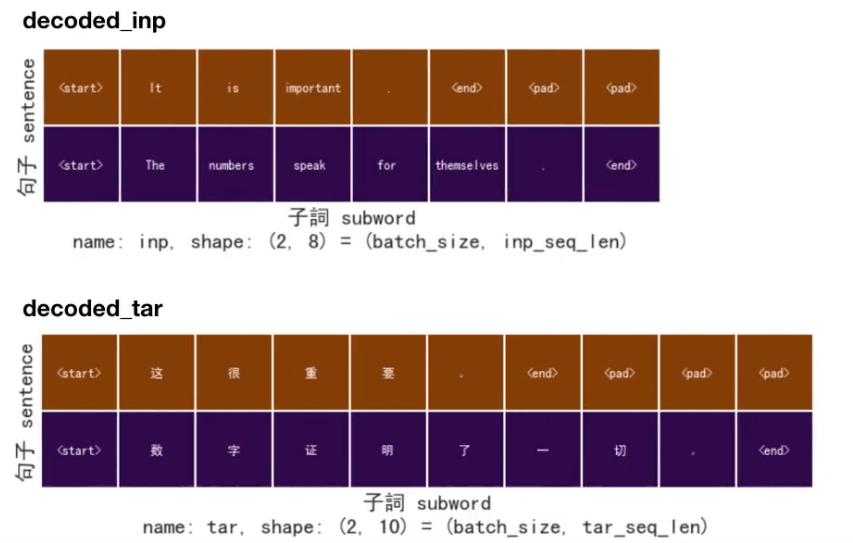

你可以清楚地看到每个原始句子前后都有<start>与<end>。而为了让同个batch里头的序列长度相同，我们在较短的序列后面也补上足够的0，代表着<pad>。

这个可视化非常简单，但十分强大。我现在要你记住一些本文会使用的惯例：

不管张量（Tensor）变几维，其第一个维度shape[0]永远代表batch_size，也就代表着句子的数目
不同句子我们用不同颜色表示，方便你之后对照这些句子在转换前后的差异
x轴（横轴）代表张量的最后一个维度shape[-1]，以上例来说分别为8和10
x，y轴上的标签分别代表倒数两个维度shape[-2]及shape[-1]其所代表的物理含义，如图中的句子与子词
图中张量的name会对应到代码里头定义的变数名称，方便你对照并理解实作逻辑。我也会秀出张量的shape帮助你想像该向量在多维空间的长相。一个简单的例子是：（batch_size，tar_seq_len）

这些准则与信息现在看似多余，但我保证你很快就会需要它们。

### 5.3 可视化3维词嵌入张量

在将索引序列丢入神经网络之前，我们一般会做词嵌入（word embedding），将一个维度为字典大小的高维离散空间「嵌入」到低维的连续空间里头。

让我们为英文与中文分别建立一个词嵌入层并实际对inp及tar做转换：

In [42]:
# + 2 是因為我們額外加了 <start> 以及 <end> tokens
vocab_size_en = subword_encoder_en.vocab_size + 2
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# 为了方便demo，将词汇转换到一个4维的词嵌入空间
d_model = 4
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
emb_inp, emb_tar

(<tf.Tensor: id=1310324, shape=(2, 8, 4), dtype=float32, numpy=
 array([[[-0.00545723,  0.03992254, -0.01982259, -0.04844166],
         [ 0.03989668, -0.04674974,  0.0239259 , -0.04646577],
         [-0.00706308,  0.03343752,  0.00602305, -0.034848  ],
         [ 0.01954545,  0.00534642, -0.02410775, -0.0319555 ],
         [ 0.0265792 ,  0.03535045, -0.03912325,  0.03359799],
         [ 0.03269727, -0.03761631,  0.027905  ,  0.04033178],
         [-0.03809232, -0.00091883,  0.00183447,  0.04710683],
         [-0.03809232, -0.00091883,  0.00183447,  0.04710683]],
 
        [[-0.00545723,  0.03992254, -0.01982259, -0.04844166],
         [ 0.00273737, -0.02226809,  0.04857281,  0.00223783],
         [ 0.04128387,  0.02447079,  0.00275277, -0.03385913],
         [ 0.03088847,  0.04305178, -0.00865518, -0.04821467],
         [-0.0089452 , -0.03148481, -0.03864438,  0.02478306],
         [-0.04592626, -0.03434762,  0.01952081, -0.00068371],
         [ 0.0265792 ,  0.03535045, -0.03912325,  0

注意你的词嵌入层的随机初始值会跟我不同，结果可能会有一点差异。
但重点是你能在脑海中理解这两个3维张量吗？花了几秒钟？我相信在座不乏各路高手，而且事实上在这一行混久了，你也必须能直觉地理解这个表示方式。
但如果有更好的呈现方式帮助我们理解数据，何乐而不为呢？让我们再次可视化这两个3维词嵌入张量：

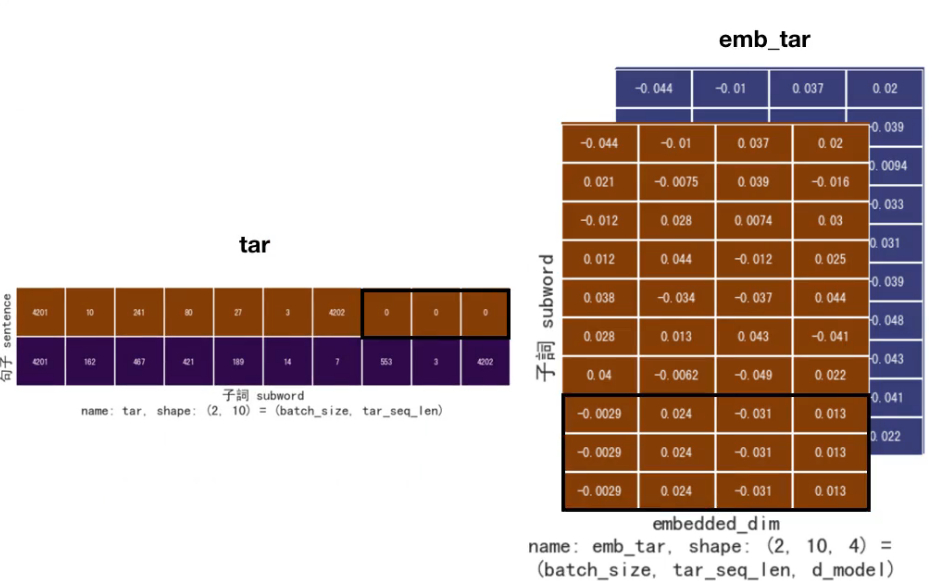

依照前面提过的准则，张量中第一个维度的2代表着句子数batch_size。在3维空间里头，我会将不同句子画在z轴上，也就是你现在把脸贴近/远离屏幕这个维度。你同时也能用不同颜色来区分句子。

紧跟着句子的下一个维度则一样是本来的子词（subword）。只是现在每个子词都已从一个索引数字被转换成一个4维的词嵌入向量，因此每个子词都以y轴来表示。最后一维则代表着词嵌入空间的维度，一样以x轴来表示。

在学会怎么解读这个3维词嵌入张量以后，你就能明白为何emb_tar第一个中文句子里头的倒数3行（row）都长得一样了：

In [43]:
print("tar[0]:", tar[0][-3:])
print("-" * 20)
print("emb_tar[0]:", emb_tar[0][-3:])

tar[0]: tf.Tensor([0 0 0], shape=(3,), dtype=int64)
--------------------
emb_tar[0]: tf.Tensor(
[[ 0.01235236 -0.02021729  0.01218241 -0.00257816]
 [ 0.01235236 -0.02021729  0.01218241 -0.00257816]
 [ 0.01235236 -0.02021729  0.01218241 -0.00257816]], shape=(3, 4), dtype=float32)


它们都是<pad> token（以0表示），理当有一样的词嵌入向量。

不同颜色也让我们可以很直观地理解一个句子是怎么从一个1维向量被转换到2维的。你后面就会发现，你将需要能够非常直觉地理解像是emb_tar这种3维张量里头每个维度所代表的意义。

### 5.4 掩码：Transformer的秘密配方

我们在前面并没有仔细谈过掩码（masking）的概念，但事实上它可以说是在实作Transformer时最重要却也最容易被搞砸的一环。它让Transformer在进行自注意力机制（Self-Attention Mechanism）时不至于偷看到不该看的。

在Transformer里头有两种masks：  
padding mask  
look ahead mask  
padding mask是让Transformer用来识别序列实际的内容到哪里。此掩码负责的就是将序列中被补0的地方（也就是<pad>）的位置盖住，让Transformer可以避免「关注」到这些位置。
look ahead mask人如其名，是用来确保Decoder在进行自注意力机制时每个子词只会「往前看」：关注（包含）自己之前的字词，不会不小心关注「未来」Decoder产生的子词。我们后面还会看到look ahead mask的详细介绍，但不管是哪一种掩码向量，那些值为1的位置就是掩码存在的地方。

In [44]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

inp_mask = create_padding_mask(inp)
inp_mask

<tf.Tensor: id=1310361, shape=(2, 1, 1, 8), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 1., 1.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=float32)>

我们的第一个4维张量！不过别紧张，我们在中间加了2个新维度是为了之后可以做广播(broadcasting)，现在可以忽视。喔！不过如果这是你第一次听到broadcasting，我强烈建议你现在就阅读numpy官方的简短教学了解其概念。我们后面也会看到实际的broadcasting例子。

回到我们的inp_mask掩码。现在我们可以先将额外的维度去掉以方便跟inp作比较：

In [45]:
print("inp:", inp)
print("-" * 20)
print("tf.squeeze(inp_mask):", tf.squeeze(inp_mask))

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
tf.squeeze(inp_mask): tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


你可以看到inp_mask将inp里头为0的对应位置设为1凸显出来，这样之后其他函式就知道要把哪边「遮住」。让我们看看被降到2维的inp_mask是怎么被套用在inp身上的：

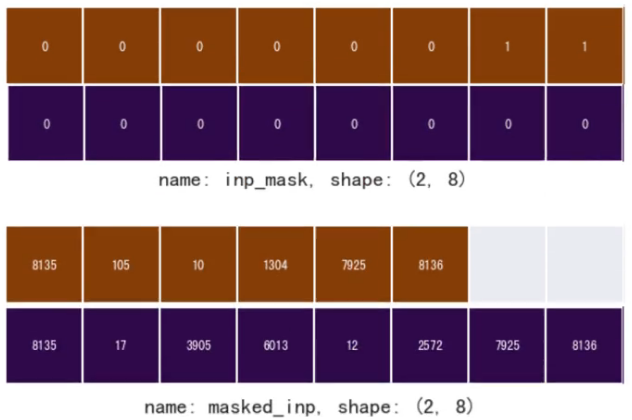

### 5.5 Scaled dot product attention：一种注意函式

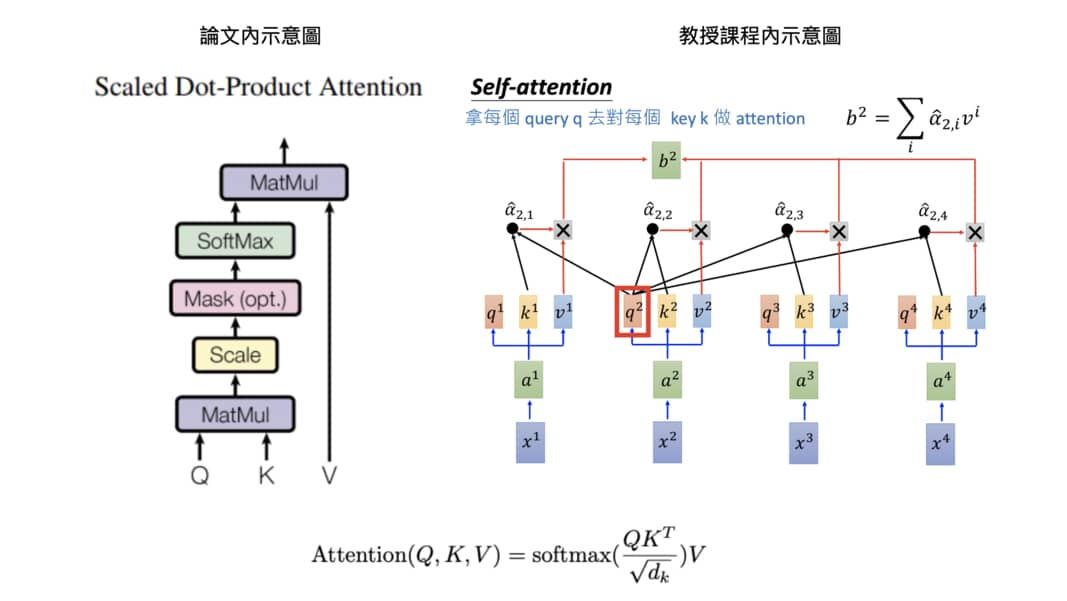

左右两边大致上讲的是一样的事情，不过右侧省略Scale以及Mask步骤，而左侧则假设我们已经拿到经过线性转换的Q，K，V

我们是第一次秀出论文里头的图片（左），但右边你应该不陌生才对。
Scaled dot product attention跟以往multiplicative attention一样是先将维度相同的Q跟K做点积：将对应维度的值两两相乘后相加得到单一数值，接着把这些数值除以一个scaling factor sqrt（dk），然后再丢入softmax函式得到相加为1的注意权重（attention weights）。
最后以此权重对V作加权平均得到输出结果。
除以scaling factor的目的是为了让点积出来的值不会因为Q以及K的维度dk太大而跟着太大（舌头打结）。因为太大的点积值丢入softmax函式有可能使得其梯度变得极小，导致训练结果不理想。

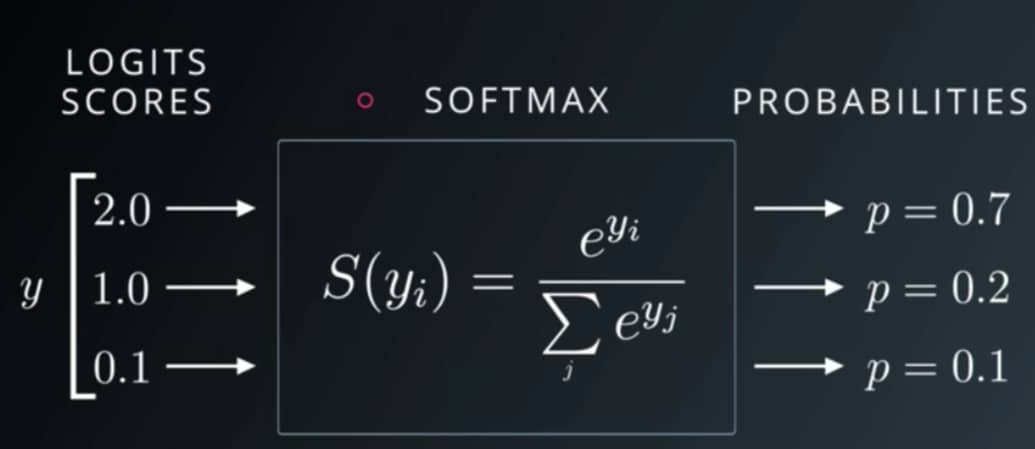

说完概念，让我们看看Transformer论文中的这个注意函式怎么运作吧！首先我们得先准备这个函式的输入Q，K，V才行。我们在Multi-head attention一节会看到，在进行scaled dot product attention时会需要先将Q、K以及V分别做一次线性转换，但现在让我们先忽略这部分。

这边我们可以拿已经被转换成词嵌入空间的英文张量emb_inp来充当左图中的Q以及K，让它自己跟自己做匹配。V则让我随机产生一个binary张量（里头只有1或0）来当作每个K所对应的值，方便我们直观解读scaled dot product attention的输出结果：

In [46]:
# 設定一個 seed 確保我們每次都拿到一樣的隨機結果
tf.random.set_seed(9527)

# 自注意力机制：查詢 `q` 跟鍵值 `k` 都是 `emb_inp`
q = emb_inp
k = emb_inp
# 简单产生一个跟 `emb_inp` 同样shape 的 binary vector
v = tf.cast(tf.math.greater(tf.random.uniform(shape=emb_inp.shape), 0.5), tf.float32)
v

<tf.Tensor: id=1310372, shape=(2, 8, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 1.]],

       [[1., 0., 1., 1.],
        [1., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.]]], dtype=float32)>

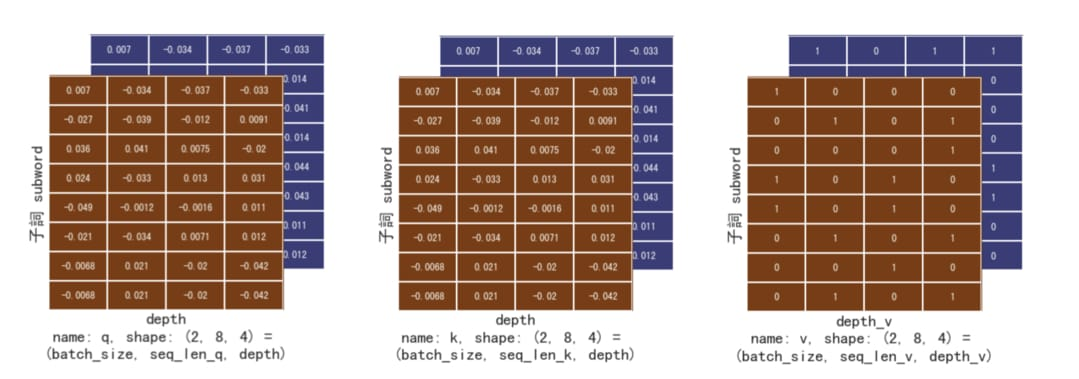

注意颜色。虽然我们将拿Q跟K来做匹配，这个匹配只会发生在同个句子（同个颜色）底下（即shape[1:]）。在深度学习世界，我们会为了最大化GPU的运算效率而一次将64个、128个或是更多个batch_size的句子丢入模型。习惯batch维度的存在是非常实际的。

接着让我们看看scaled dot product attention在TensorFlow里是怎么被实作的：

In [53]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """
  # 將 `q`、 `k` 做點積再 scale
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)  # 取得 seq_k 的序列長度
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

  # 將遮罩「加」到被丟入 softmax 前的 logits
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # 取 softmax 是為了得到總和為 1 的比例之後對 `v` 做加權平均
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
  # 以注意權重對 v 做加權平均（weighted average）
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [54]:
mask = None
output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("output:", output)
print("-" * 20)
print("attention_weights:", attention_weights)

output: tf.Tensor(
[[[0.37540695 0.37456    0.37499985 0.49973556]
  [0.37489876 0.37531847 0.37469184 0.5003204 ]
  [0.3752126  0.37472892 0.37494162 0.49987724]
  [0.3752706  0.3748264  0.37499365 0.49988124]
  [0.37528402 0.3747571  0.37528723 0.49970913]
  [0.37464026 0.37547758 0.37494797 0.5003104 ]
  [0.3747723  0.37507087 0.37513632 0.49999085]
  [0.3747723  0.37507087 0.37513632 0.49999085]]

 [[0.62538284 0.24977544 0.62497526 0.3750335 ]
  [0.6250677  0.250037   0.6252394  0.37491834]
  [0.62524414 0.2496337  0.62497425 0.37474483]
  [0.62537074 0.24958375 0.62494993 0.3748019 ]
  [0.62464947 0.25026974 0.62483054 0.37518   ]
  [0.625041   0.25033873 0.6252263  0.37527856]
  [0.62470484 0.24983199 0.62464774 0.37484342]
  [0.62466395 0.25006443 0.62502354 0.37480024]]], shape=(2, 8, 4), dtype=float32)
--------------------
attention_weights: tf.Tensor(
[[[0.12526456 0.12497236 0.12517558 0.12512493 0.12501746 0.12473018
   0.12485746 0.12485746]
  [0.1249878  0.1254145  0.125

加了padding mask后，第一个句子每个子词针对倒数两个字词的「注意权重」的值都变成0了。把这句话翻译成numpy的slice语法。

In [55]:
# 事實上也不完全是上句話的翻譯，
# 因為我們在第一個維度還是把兩個句子都拿出來方便你比較
attention_weights[:, :, -2:]

<tf.Tensor: id=1310414, shape=(2, 8, 2), dtype=float32, numpy=
array([[[0.12485746, 0.12485746],
        [0.12478085, 0.12478085],
        [0.12491012, 0.12491012],
        [0.12484816, 0.12484816],
        [0.12500687, 0.12500687],
        [0.12504935, 0.12504935],
        [0.12523684, 0.12523684],
        [0.12523684, 0.12523684]],

       [[0.12501097, 0.1247237 ],
        [0.12484608, 0.1251531 ],
        [0.12500982, 0.12491132],
        [0.12503073, 0.12478983],
        [0.12507504, 0.12506373],
        [0.12483075, 0.12505122],
        [0.12527429, 0.12497319],
        [0.12498487, 0.12530316]]], dtype=float32)>

第一个英文句子的最后2个位置因为是<pad>所以被掩码「盖住」而没有权重值（上方2维数组）；第二个句子的序列（下方2维数组）则因为最后2个位置仍是正常的英文子词，因此都有被其他子词关注。

如果你还是无法理解以上结果，或是不确定有掩码的注意函式到底怎么运作，就实际看看其中的计算过程吧！

让我们看看前面提过的另一种掩码look ahead mask：

In [56]:
# 建立一個 2 維矩陣，維度為 (size, size)，
# 其遮罩為一個右上角的三角形
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

seq_len = emb_tar.shape[1] # 注意這次我們用中文的詞嵌入張量 `emb_tar`
look_ahead_mask = create_look_ahead_mask(seq_len)
print("emb_tar:", emb_tar)
print("-" * 20)
print("look_ahead_mask", look_ahead_mask)

emb_tar: tf.Tensor(
[[[-0.01566951 -0.01924285  0.0054651  -0.00198431]
  [-0.02534711 -0.04176586 -0.01076071 -0.02489797]
  [-0.00945232  0.00506997  0.03564611 -0.02001262]
  [ 0.02927876 -0.02732419 -0.03353093 -0.0445521 ]
  [ 0.03306388  0.02954252 -0.00336207 -0.04536191]
  [-0.00494137  0.00338602 -0.00304532  0.04331691]
  [ 0.00617601 -0.04323471 -0.01662131  0.0096743 ]
  [ 0.01235236 -0.02021729  0.01218241 -0.00257816]
  [ 0.01235236 -0.02021729  0.01218241 -0.00257816]
  [ 0.01235236 -0.02021729  0.01218241 -0.00257816]]

 [[-0.01566951 -0.01924285  0.0054651  -0.00198431]
  [ 0.03661963 -0.01853368 -0.04688709  0.0028834 ]
  [-0.00246008 -0.00533096 -0.01392286  0.03006107]
  [-0.03505892 -0.018986   -0.01416345  0.01743588]
  [ 0.01137213 -0.01201544  0.00933304 -0.04217238]
  [-0.04253895  0.04425148 -0.04791594  0.02122691]
  [-0.0414755  -0.04231116  0.0313305   0.04893686]
  [-0.03736231 -0.00758398  0.00152459 -0.04874502]
  [-0.00494137  0.00338602 -0.00304532  0.

我们已经知道demo用的中文（目标语言）的序列长度为10，而look ahead掩码就是产生一个2维矩阵，其两个维度都跟中文的词嵌入张量emb_tar的倒数第2个维度（序列长度）一样，且里头是一个倒三角形（1的部分）。
我们前面曾经说过look_ahead_mask是用来确保Decoder在进行自注意力机制时输出序列里头的每个子词只会关注到自己之前（左边）的字词，不会不小心关注到未来（右边）理论上还没被Decoder生成的子词。

运用从padding mask学到的概念，想像一下如果把这个倒三角的掩码跟之前一样套用到进入softmax之前的scaled_attention_logits，输出序列output里头的每个子词的repr.会有什么性质？

温馨小提醒：scaled_attention_logits里头的每一row纪录了某个特定子词对其他子词的注意权重。

In [57]:
# 讓我們用目標語言（中文）的 batch
# 來模擬 Decoder 處理的情況
temp_q = temp_k = emb_tar
temp_v = tf.cast(tf.math.greater(
    tf.random.uniform(shape=emb_tar.shape), 0.5), tf.float32)

# 將 look_ahead_mask 放入注意函式
_, attention_weights = scaled_dot_product_attention(
    temp_q, temp_k, temp_v, look_ahead_mask)

print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[1.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.4997586  0.5002414  0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.33325782 0.33323407 0.33350804 0.         0.         0.
   0.         0.         0.         0.        ]
  [0.2498141  0.25005114 0.24972777 0.25040695 0.         0.
   0.         0.         0.         0.        ]
  [0.19979785 0.19980869 0.19996177 0.20012872 0.20030296 0.
   0.         0.         0.         0.        ]
  [0.1667178  0.16663682 0.16664934 0.16655327 0.16655718 0.16688558
   0.         0.         0.         0.        ]
  [0.1428635  0.14293222 0.1427429  0.14292517 0.1427149  0.14283974
   0.14298154 0.         0.         0.        ]
  [0.12499587 0.1250082  0.12499583 0.12501794 0.12497211 0.12496178
   0.12502435 0.12502395 0.         0.        ]
  [0.11110507 0.11111602 0.11110503 0.11112469 0.11108395 0.11107477
   0.

答案呼之欲出，套用look ahead mask的结果就是让序列q里的每个字词只关注包含自己左侧的子词，在自己之后的位置的字词都不看。比方说两个中文句子的第一个字词都只关注自己：

In [58]:
attention_weights[:, 0, :]

<tf.Tensor: id=1310450, shape=(2, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

注意到了吗？两个句子的第一个子词因为自己前面已经没有其他子词，所以将全部的注意力1都放在自己身上。让我们看看第二个子词：

In [59]:
attention_weights[:, 1, :]

<tf.Tensor: id=1310454, shape=(2, 10), dtype=float32, numpy=
array([[0.4997586, 0.5002414, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.4994537, 0.5005463, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ]], dtype=float32)>

### 5.6 Multi-head attention：你看你的，我看我的

有好好听教授讲解Transformer的话，你应该还记得所谓的多头注意（multi-head attention）概念。如果你到现在还没看课程视频或者想复习一下，我把multi-head attention的开始跟结束时间都设置好了

mutli-head attention的概念本身并不难，用比较正式的说法就是将Q、K以及V这三个张量先个别转换到d_model维空间，再将其拆成多个比较低维的depth维度N次以后，将这些产生的小q、小k以及小v分别丢入前面的注意函式得到N个结果。接着将这N个heads的结果串接起来，最后通过一个线性转换就能得到multi-head attention的输出

而为何要那么「搞刚」把本来d_model维的空间投影到多个维度较小的子空间（subspace）以后才各自进行注意力机制呢？这是因为这给予模型更大的弹性，让它可以同时关注不同位置的子词在不同子空间下的representation，而不只是本来d_model维度下的一个representation。

我们在文章最开头看过的英翻中就是一个活生生的mutli-head attention例子：

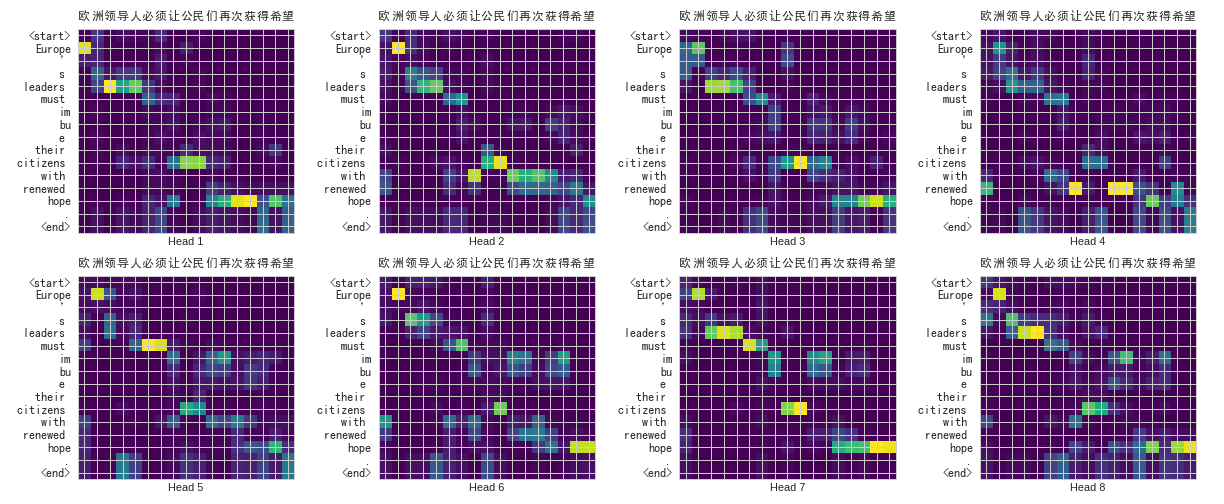

为了要实现multi-head attention，得先能把一个head变成多个heads。而这实际上就是把一个d_model维度的向量「折」成num_heads个depth维向量，使得：

In [61]:
# num_heads * depth = d_model

让我们实作一个可以做到这件事情的函式，并将英文词嵌入张量emb_inp实际丢进去看看

In [62]:
def split_heads(x, d_model, num_heads):
  # x.shape: (batch_size, seq_len, d_model)
  batch_size = tf.shape(x)[0]
  
  # 我們要確保維度 `d_model` 可以被平分成 `num_heads` 個 `depth` 維度
  assert d_model % num_heads == 0
  depth = d_model // num_heads  # 這是分成多頭以後每個向量的維度 
  
  # 將最後一個 d_model 維度分成 num_heads 個 depth 維度。
  # 最後一個維度變成兩個維度，張量 x 從 3 維到 4 維
  # (batch_size, seq_len, num_heads, depth)
  reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))
  
  # 將 head 的維度拉前使得最後兩個維度為子詞以及其對應的 depth 向量
  # (batch_size, num_heads, seq_len, depth)
  output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
  
  return output

# 我們的 `emb_inp` 裡頭的子詞本來就是 4 維的詞嵌入向量
d_model = 4
# 將 4 維詞嵌入向量分為 2 個 head 的 2 維矩陣
num_heads = 2
x = emb_inp

output = split_heads(x, d_model, num_heads)  
print("x:", x)
print("output:", output)

x: tf.Tensor(
[[[-0.00545723  0.03992254 -0.01982259 -0.04844166]
  [ 0.03989668 -0.04674974  0.0239259  -0.04646577]
  [-0.00706308  0.03343752  0.00602305 -0.034848  ]
  [ 0.01954545  0.00534642 -0.02410775 -0.0319555 ]
  [ 0.0265792   0.03535045 -0.03912325  0.03359799]
  [ 0.03269727 -0.03761631  0.027905    0.04033178]
  [-0.03809232 -0.00091883  0.00183447  0.04710683]
  [-0.03809232 -0.00091883  0.00183447  0.04710683]]

 [[-0.00545723  0.03992254 -0.01982259 -0.04844166]
  [ 0.00273737 -0.02226809  0.04857281  0.00223783]
  [ 0.04128387  0.02447079  0.00275277 -0.03385913]
  [ 0.03088847  0.04305178 -0.00865518 -0.04821467]
  [-0.0089452  -0.03148481 -0.03864438  0.02478306]
  [-0.04592626 -0.03434762  0.01952081 -0.00068371]
  [ 0.0265792   0.03535045 -0.03912325  0.03359799]
  [ 0.03269727 -0.03761631  0.027905    0.04033178]]], shape=(2, 8, 4), dtype=float32)
output: tf.Tensor(
[[[[-0.00545723  0.03992254]
   [ 0.03989668 -0.04674974]
   [-0.00706308  0.03343752]
   [ 0.0195

观察output与emb_inp之间的关系，你会发现3维词嵌入张量emb_inp已经被转换成一个4维张量了，且最后一个维度shape[-1] = 4被拆成两半。

不过如果你不熟TensorFlow API或是矩阵运算，或许无法马上理解head的维度在哪里、还有不同heads之间有什么差异。为了帮助你直观理解split_heads函式，我将运算过程中产生的张量都可视化出来给你瞧瞧：

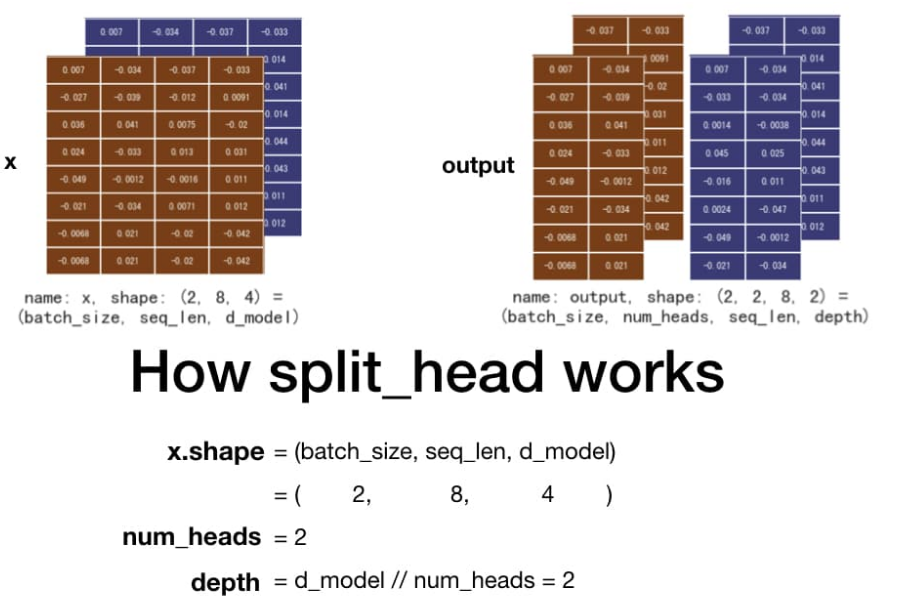

明白如何产生multi-head的4维张量以后，multi-head attention的实现就比较容易理解了：

In [65]:
# 在初始的時候指定輸出維度 `d_model` & `num_heads，
# 在呼叫的時候輸入 `v`, `k`, `q` 以及 `mask`
# 輸出跟 scaled_dot_product_attention 函式一樣有兩個：
# output.shape            == (batch_size, seq_len_q, d_model)
# attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
class MultiHeadAttention(tf.keras.layers.Layer):
  # 在初始的時候建立一些必要參數
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads # 指定要將 `d_model` 拆成幾個 heads
    self.d_model = d_model # 在 split_heads 之前的基底維度
    
    assert d_model % self.num_heads == 0  # 前面看過，要確保可以平分
    
    self.depth = d_model // self.num_heads  # 每個 head 裡子詞的新的 repr. 維度
    
    self.wq = tf.keras.layers.Dense(d_model)  # 分別給 q, k, v 的 3 個線性轉換 
    self.wk = tf.keras.layers.Dense(d_model)  # 注意我們並沒有指定 activation func
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)  # 多 heads 串接後通過的線性轉換
  
  # 這跟我們前面看過的函式有 87% 相似
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  
  # multi-head attention 的實際執行流程，注意參數順序（這邊跟論文以及 TensorFlow 官方教學一致）
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    # 將輸入的 q, k, v 都各自做一次線性轉換到 `d_model` 維空間
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    # 前面看過的，將最後一個 `d_model` 維度分成 `num_heads` 個 `depth` 維度
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # 利用 broadcasting 讓每個句子的每個 head 的 qi, ki, vi 都各自進行注意力機制
    # 輸出會多一個 head 維度
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    
    # 跟我們在 `split_heads` 函式做的事情剛好相反，先做 transpose 再做 reshape
    # 將 `num_heads` 個 `depth` 維度串接回原來的 `d_model` 維度
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model)) 
    # (batch_size, seq_len_q, d_model)

    # 通過最後一個線性轉換
    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

差别只在于实际上我们是利用矩阵运算以及broadcasting让GPU一次计算整个batch里所有句子的所有head的注意结果。

定义了一个新layer当然要实际试试。现在让我们初始一个multi-head attention layer并将英文词嵌入向量emb_inp输入进去看看：

In [66]:
# emb_inp.shape == (batch_size, seq_len, d_model)
#               == (2, 8, 4)
assert d_model == emb_inp.shape[-1]  == 4
num_heads = 2

print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}\n")

# 初始化一個 multi-head attention layer
mha = MultiHeadAttention(d_model, num_heads)

# 簡單將 v, k, q 都設置為 `emb_inp`
# 順便看看 padding mask 的作用。
# 別忘記，第一個英文序列的最後兩個 tokens 是 <pad>
v = k = q = emb_inp
padding_mask = create_padding_mask(inp)
print("q.shape:", q.shape)
print("k.shape:", k.shape)
print("v.shape:", v.shape)
print("padding_mask.shape:", padding_mask.shape)

output, attention_weights = mha(v, k, q, mask)
print("output.shape:", output.shape)
print("attention_weights.shape:", attention_weights.shape)

print("\noutput:", output)

d_model: 4
num_heads: 2

q.shape: (2, 8, 4)
k.shape: (2, 8, 4)
v.shape: (2, 8, 4)
padding_mask.shape: (2, 1, 1, 8)
output.shape: (2, 8, 4)
attention_weights.shape: (2, 2, 8, 8)

output: tf.Tensor(
[[[ 0.00103047 -0.00076246  0.00017847  0.00061601]
  [ 0.00109735 -0.00084141  0.00013566  0.00064771]
  [ 0.00104926 -0.00078514  0.00017041  0.00063482]
  [ 0.0010662  -0.00080216  0.0001483   0.00061513]
  [ 0.00110174 -0.00083742  0.00011522  0.00060627]
  [ 0.00115681 -0.0009069   0.00008992  0.00065838]
  [ 0.00111202 -0.0008594   0.00012271  0.00065039]
  [ 0.00111202 -0.0008594   0.00012271  0.00065039]]

 [[-0.00008508  0.00165634  0.0027554  -0.00144131]
  [ 0.00002886  0.00152205  0.00269573 -0.00136804]
  [-0.00003332  0.00159669  0.00271241 -0.00142935]
  [-0.00006593  0.00163508  0.00273293 -0.00144561]
  [ 0.00001018  0.00154442  0.00270345 -0.00138894]
  [-0.00000144  0.00155494  0.00272739 -0.00136543]
  [-0.00000169  0.00156613  0.00269656 -0.00142382]
  [ 0.00007566  0.001

你现在应该明白为何我们当初要在padding mask 加入两个新维度了：一个是用来遮住同个句子但是不同head 的注意权重，一个则是用来broadcast 到2 维注意权重的（详见直观理解遮罩一节）。
没意外的话你也已经能够解读 mutli-head attention 的输出了：
output：序列中每个子词的新 repr. 都包含同序列其他位置的资讯
attention_weights：包含每个 head 的每个序列 q 中的字词对序列 k 的注意权重
如果你还无法想像每个计算步骤，让我们看看 multi-head attention 是怎么将输入的 q、k 以及 v 转换成最后的 output 的：

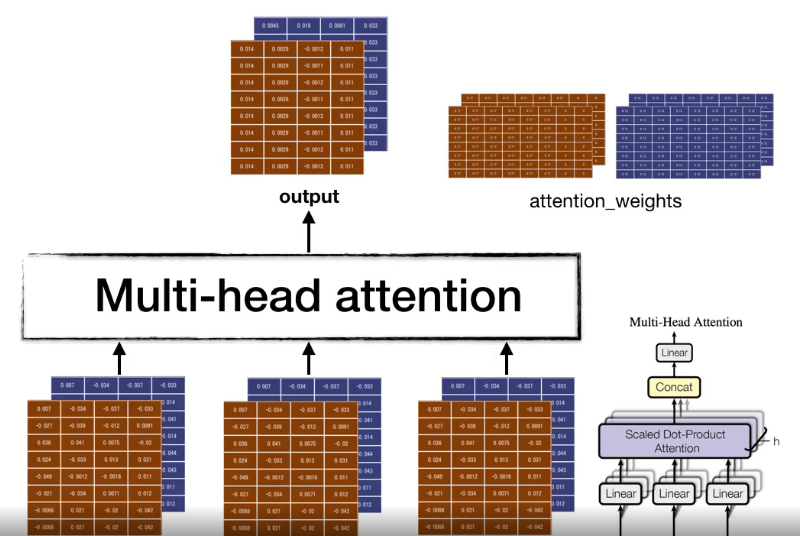

这应该是你这辈子第一次也可能是唯一一次有机会看到 multi-head 注意力机制是怎么处理 4 维张量的。
细节不少，我建议将动画跟程式码比较一下，确保你能想像每一个步骤产生的张量以及其物理意义。到此为止，我们已经把 Transformer 里最困难的 multi-head attention 的概念以及运算都看过一遍了。
如果你脑袋还是一团乱，只要记得最后一个画面：在q、k 以及v 的最后一维已经是d_model 的情况下，multi-head attention 跟scaled dot product attention 一样，就是吐出一个完全一样维度的张量output。
multi-head attention 的输出张量output 里头每个句子的每个字词的repr. 维度d_model 虽然跟函式的输入张量相同，但实际上已经是从同个序列中不同位置且不同空间中的repr. 取得语义资讯的结果。
要确保自己真的掌握了 multi-head attention 的精神，你可以试着向旁边的朋友（如果他 / 她愿意听的话）解释一下整个流程。

https://leemeng.tw/images/transformer/multi-head-attention.mp4

## 6 打造 Transformer
以前我们曾提到深度学习模型就是一层层的几何运算过程。 Transformer 也不例外，刚才实作的 mutli-head attention layer 就是一个最明显的例子。而它正好是 Transformer 里头最重要的一层运算。

在这节我们会把 Transformer 里头除了注意力机制的其他运算通通实作成一个个的 layers，并将它们全部「叠」起来。
你可以点击下方的影片来了解接下来的实作顺序：

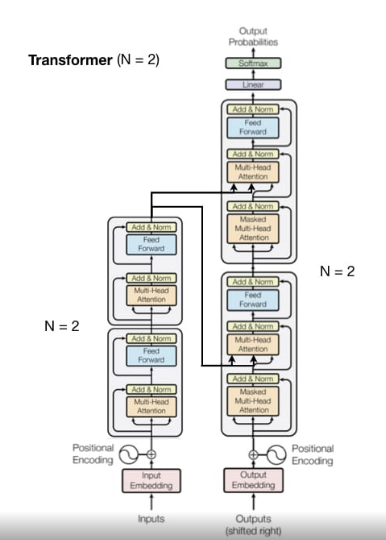

左侧就是我们接下来会依序实作的 layers。 Transformer 是一种使用自注意力机制的 Seq2Seq 模型 ，里头包含了两个重要角色，分别为 Encoder 与 Decoder：

最初输入的英文序列会通过 Encoder 中 N 个 Encoder layers 并被转换成一个相同长度的序列。每个 layer 都会为自己的输入序列里头的子词产生新的 repr.，然后交给下一个 layer。
Decoder 在生成（预测）下一个中文子词时会一边观察 Encoder 输出序列里所有英文子词的 repr.，一边观察自己前面已经生成的中文子词。
值得一提的是，N = 1 （Encoder / Decoder layer 数目 = 1）时就是最阳春版的 Transformer。但在深度学习领域里头我们常常想对原始数据做多层的转换，因此会将 N 设为影片最后出现的 2 层或是 Transformer 论文中的 6 层 Encoder / Decoder layers。

Encoder 里头的 Encoder layer 里又分两个 sub-layers，而 Decoder 底下的 Decoder layer 则包含 3 个 sub-layers。真的是 layer layer 相扣。将这些 layers 的阶层关系简单列出来大概就长这样（位置 Encoding 等实作时解释）：

### 6.1 Position-wise Feed-Forward Networks
如同影片中所看到的， Encoder layer 跟 Decoder layer 里头都各自有一个 Feed Forward 的元件。此元件构造简单，不用像前面的multi-head attention 建立客制化的keras layer，只需要写一个Python 函式让它在被呼叫的时候回传一个新的tf.keras.Sequential 模型给我们即可：

In [67]:
# 建立 Transformer 裡 Encoder / Decoder layer 都有使用到的 Feed Forward 元件
def point_wise_feed_forward_network(d_model, dff):
  
  # 此 FFN 對輸入做兩個線性轉換，中間加了一個 ReLU activation func
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

此函式在每次被呼叫的时候都会回传一组新的全连接前馈神经网路（Fully-connected Feed Forward Network，FFN），其输入张量与输出张量的最后一个维度皆为d_model ，而在FFN 中间层的维度则为dff。一般会让 dff 大于 d_model，让 FFN 从输入的 d_model 维度里头撷取些有用的资讯。在论文中 d_model 为 512，dff 则为 4 倍的 2048。两个都是可以调整的超参数。

让我们建立一个 FFN 试试：

In [68]:
batch_size = 64
seq_len = 10
d_model = 512
dff = 2048

x = tf.random.uniform((batch_size, seq_len, d_model))
ffn = point_wise_feed_forward_network(d_model, dff)
out = ffn(x)
print("x.shape:", x.shape)
print("out.shape:", out.shape)

x.shape: (64, 10, 512)
out.shape: (64, 10, 512)


在输入张量的最后一维已经是 d_model 的情况，FFN 的输出张量基本上会跟输入一模一样：

输入：（batch_size, seq_len, d_model）  
输出：（batch_size, seq_len, d_model）  
FFN 输出 / 输入张量的 shape 相同很容易理解。比较没那么明显的是这个 FFN 事实上对序列中的所有位置做的线性转换都是一样的。我们可以假想一个 2 维的 duumy_sentence，里头有 5 个以 4 维向量表示的子词：

In [69]:
dff = 6

# 建立一個小 FFN
small_ffn = point_wise_feed_forward_network(d_model, dff)
# 懂子詞梗的站出來
dummy_sentence = tf.constant([[5, 5, 6, 6], 
                              [5, 5, 6, 6], 
                              [9, 5, 2, 7], 
                              [9, 5, 2, 7],
                              [9, 5, 2, 7]], dtype=tf.float32)
small_ffn(dummy_sentence)

<tf.Tensor: id=1310794, shape=(5, 512), dtype=float32, numpy=
array([[-0.08235165, -0.653414  , -0.43677318, ...,  0.36419111,
         0.89913046, -0.0208368 ],
       [-0.08235165, -0.653414  , -0.43677318, ...,  0.36419111,
         0.89913046, -0.0208368 ],
       [-0.2414346 , -0.62221706, -0.36882126, ...,  0.27483356,
         0.8702736 , -0.0908681 ],
       [-0.2414346 , -0.62221706, -0.36882126, ...,  0.27483356,
         0.8702736 , -0.0908681 ],
       [-0.2414346 , -0.62221706, -0.36882126, ...,  0.27483356,
         0.8702736 , -0.0908681 ]], dtype=float32)>

你会发现同一个子词不会因为位置的改变而造成 FFN 的输出结果产生差异。但因为我们实际上会有多个 Encoder / Decoder layers，而每个 layers 都会有不同参数的 FFN，因此每个 layer 里头的 FFN 做的转换都会有所不同。

值得一提的是，尽管对所有位置的子词都做一样的转换，这个转换是独立进行的，因此被称作 Position-wise Feed-Forward Networks

### 6.2 Encoder layer
有了 Multi-Head Attention（MHA）以及 Feed-Forward Network（FFN），我们事实上已经可以实作第一个 Encoder layer 了。让我们复习一下这 layer 里头有什么重要元件：

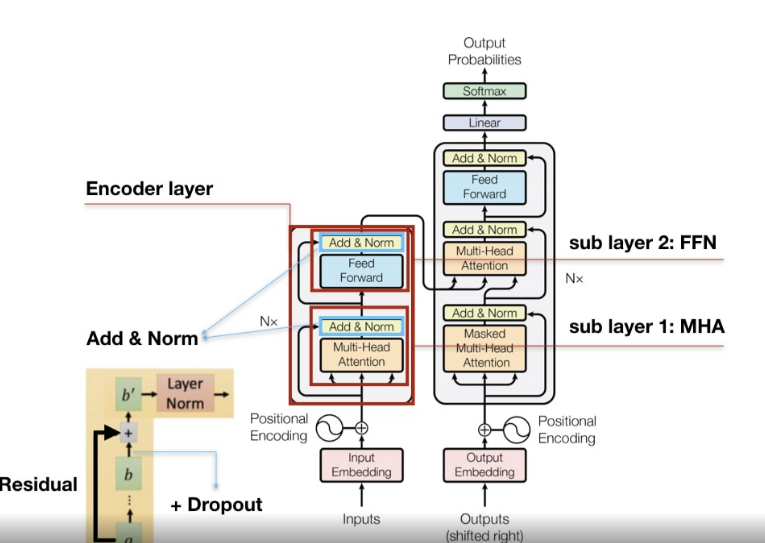

一个 Encoder layer 里头会有两个 sub-layers，分别为 MHA 以及 FFN。在 Add & Norm 步骤里头，每个 sub-layer 会有一个残差连结（residual connection）来帮助减缓梯度消失（Gradient Vanishing）的问题。接着两个 sub-layers 都会针对最后一维 d_model 做 layer normalization，将 batch 里头每个子词的输出独立做转换，使其平均与标准差分别靠近 0 和 1 之后输出。

另外在将 sub-layer 的输出与其输入相加之前，我们还会做点 regularization，对该 sub-layer 的输出使用 dropout。
总结一下。如果输入是 x，最后输出写作 out 的话，则每个 sub-layer 的处理逻辑如下：

Sublayer 则可以是 MHA 或是 FFN。现在让我们看看 Encoder layer 的实作：

In [71]:
# Encoder 裡頭會有 N 個 EncoderLayers，而每個 EncoderLayer 裡又有兩個 sub-layers: MHA & FFN
class EncoderLayer(tf.keras.layers.Layer):
  # Transformer 論文內預設 dropout rate 為 0.1
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # layer norm 很常在 RNN-based 的模型被使用。一個 sub-layer 一個 layer norm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 一樣，一個 sub-layer 一個 dropout layer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  # 需要丟入 `training` 參數是因為 dropout 在訓練以及測試的行為有所不同
  def call(self, x, training, mask):
    # 除了 `attn`，其他張量的 shape 皆為 (batch_size, input_seq_len, d_model)
    # attn.shape == (batch_size, num_heads, input_seq_len, input_seq_len)
    
    # sub-layer 1: MHA
    # Encoder 利用注意機制關注自己當前的序列，因此 v, k, q 全部都是自己
    # 另外別忘了我們還需要 padding mask 來遮住輸入序列中的 <pad> token
    attn_output, attn = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training) 
    out1 = self.layernorm1(x + attn_output)  
    
    # sub-layer 2: FFN
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)  # 記得 training
    out2 = self.layernorm2(out1 + ffn_output)
    
    return out2

基本上 Encoder layer 里头就是两个架构一模一样的 sub-layer，只差在一个是 MHA，一个是 FFN。另外为了方便 residual connection 的计算，所有 sub-layers 的输出维度都是 d_model。而 sub-layer 内部产生的维度当然就随我们开心啦！我们可以为 FFN 设置不同的 dff 值，也能设定不同的 num_heads 来改变 MHA 内部每个 head 里头的维度。

论文里头的 d_model 为 512，而我们 demo 用的英文词嵌入张量的 d_model 维度则为 4：

In [72]:
# 之後可以調的超參數。這邊為了 demo 設小一點
d_model = 4
num_heads = 2
dff = 8

# 新建一個使用上述參數的 Encoder Layer
enc_layer = EncoderLayer(d_model, num_heads, dff)
padding_mask = create_padding_mask(inp)  # 建立一個當前輸入 batch 使用的 padding mask
enc_out = enc_layer(emb_inp, training=False, mask=padding_mask)  # (batch_size, seq_len, d_model)

print("inp:", inp)
print("-" * 20)
print("padding_mask:", padding_mask)
print("-" * 20)
print("emb_inp:", emb_inp)
print("-" * 20)
print("enc_out:", enc_out)
assert emb_inp.shape == enc_out.shape

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)
--------------------
emb_inp: tf.Tensor(
[[[-0.00545723  0.03992254 -0.01982259 -0.04844166]
  [ 0.03989668 -0.04674974  0.0239259  -0.04646577]
  [-0.00706308  0.03343752  0.00602305 -0.034848  ]
  [ 0.01954545  0.00534642 -0.02410775 -0.0319555 ]
  [ 0.0265792   0.03535045 -0.03912325  0.03359799]
  [ 0.03269727 -0.03761631  0.027905    0.04033178]
  [-0.03809232 -0.00091883  0.00183447  0.04710683]
  [-0.03809232 -0.00091883  0.00183447  0.04710683]]

 [[-0.00545723  0.03992254 -0.01982259 -0.04844166]
  [ 0.00273737 -0.02226809  0.04857281  0.00223783]
  [ 0.04128387  0.02447079  0.00275277 -0.03385913]
  [ 0.03088847  0.04305178 -0.00865518 -0.04821467]
  [-0.0089452  -0.03148481 -0.03864438  0.02478306]
  [

### 6.3 Decoder layer：Decoder 小弟
一个 Decoder layer 里头有 3 个 sub-layers：

Decoder layer 自身的 Masked MHA 1
Decoder layer 关注 Encoder 输出序列的 MHA 2
FFN
你也可以看一下影片来回顾它们所在的位置：

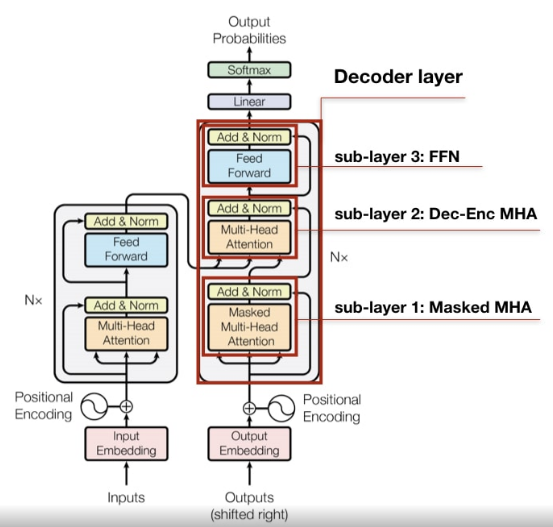

跟实作 Encoder layer 时一样，每个 sub-layer 的逻辑同下

Decoder layer 用 MHA 1 来关注输出序列，查询 Q、键值 K 以及值 V 都是自己。而之所以有个 masked 是因为（中文）输出序列除了跟（英文）输入序列一样需要 p​​adding mask 以外，还需要 look ahead mask 来避免 Decoder layer 关注到未来的子词。 look ahead mask 在前面章节已经有详细说明了。

MHA1 处理完的输出序列会成为 MHA 2 的 Q，而 K 与 V 则使用 E​​ncoder 的输出序列。这个运算的概念是让一个 Decoder layer 在生成新的中文子词时先参考先前已经产生的中文字，并为当下要生成的子词产生一个包含前文语义的 repr. 。接着将此 repr. 拿去跟 Encoder 那边的英文序列做匹配，看当下字词的 repr. 有多好并予以修正。

用简单点的说法就是 Decoder 在生成中文字词时除了参考已经生成的中文字以外，也会去关注 Encoder 输出的英文子词（的 repr.）。

In [73]:
# Decoder 裡頭會有 N 個 DecoderLayer，
# 而 DecoderLayer 又有三個 sub-layers: 自注意的 MHA, 關注 Encoder 輸出的 MHA & FFN
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    # 3 個 sub-layers 的主角們
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    # 定義每個 sub-layer 用的 LayerNorm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 定義每個 sub-layer 用的 Dropout
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    # 所有 sub-layers 的主要輸出皆為 (batch_size, target_seq_len, d_model)
    # enc_output 為 Encoder 輸出序列，shape 為 (batch_size, input_seq_len, d_model)
    # attn_weights_block_1 則為 (batch_size, num_heads, target_seq_len, target_seq_len)
    # attn_weights_block_2 則為 (batch_size, num_heads, target_seq_len, input_seq_len)

    # sub-layer 1: Decoder layer 自己對輸出序列做注意力。
    # 我們同時需要 look ahead mask 以及輸出序列的 padding mask 
    # 來避免前面已生成的子詞關注到未來的子詞以及 <pad>
    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # sub-layer 2: Decoder layer 關注 Encoder 的最後輸出
    # 記得我們一樣需要對 Encoder 的輸出套用 padding mask 避免關注到 <pad>
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, inp_padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    # sub-layer 3: FFN 部分跟 Encoder layer 完全一樣
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    # 除了主要輸出 `out3` 以外，輸出 multi-head 注意權重方便之後理解模型內部狀況
    return out3, attn_weights_block1, attn_weights_block2

Decoder layer 的实作跟 Encoder layer 大同小异，不过还是有几点细节特别需要注意：

在做 Masked MHA（MHA 1）的时候我们需要同时套用两种遮罩：输出序列的 padding mask 以及 look ahead mask。因此 Decoder layer 预期的遮罩是两者结合的 combined_mask
MHA 1 因为是 Decoder layer 关注自己，multi-head attention 的参数 v、k 以及 q 都是 x
MHA 2 是 Decoder layer 关注 Encoder 输出序列，因此，multi-head attention 的参数 v、k 为 enc_output，q 则为 MHA 1 sub-layer 的结果 out1
产生 comined_mask 也很简单，我们只要把两个遮罩取大的即可：

In [74]:
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

print("tar:", tar)
print("-" * 20)
print("tar_padding_mask:", tar_padding_mask)
print("-" * 20)
print("look_ahead_mask:", look_ahead_mask)
print("-" * 20)
print("combined_mask:", combined_mask)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
tar_padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 10), dtype=float32)
--------------------
look_ahead_mask: tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0.

这方便之后 multi-head attention 的计算。另外因为我们 demo 的中文 batch 里头的第一个句子有 <pad>，combined_mask 除了 look ahead 的效果以外还加了 padding mask。

因为刚刚实作的是 Decoder layer，这次让我们把中文（目标语言）的词嵌入张量以及相关的遮罩丢进去看看：

In [75]:
# 超參數
d_model = 4
num_heads = 2
dff = 8
dec_layer = DecoderLayer(d_model, num_heads, dff)

# 來源、目標語言的序列都需要 padding mask
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)

# masked MHA 用的遮罩，把 padding 跟未來子詞都蓋住
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

# 實際初始一個 decoder layer 並做 3 個 sub-layers 的計算
dec_out, dec_self_attn_weights, dec_enc_attn_weights = dec_layer(
    emb_tar, enc_out, False, combined_mask, inp_padding_mask)

print("emb_tar:", emb_tar)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("dec_out:", dec_out)
assert emb_tar.shape == dec_out.shape
print("-" * 20)
print("dec_self_attn_weights.shape:", dec_self_attn_weights.shape)
print("dec_enc_attn_weights:", dec_enc_attn_weights.shape)

emb_tar: tf.Tensor(
[[[-0.01566951 -0.01924285  0.0054651  -0.00198431]
  [-0.02534711 -0.04176586 -0.01076071 -0.02489797]
  [-0.00945232  0.00506997  0.03564611 -0.02001262]
  [ 0.02927876 -0.02732419 -0.03353093 -0.0445521 ]
  [ 0.03306388  0.02954252 -0.00336207 -0.04536191]
  [-0.00494137  0.00338602 -0.00304532  0.04331691]
  [ 0.00617601 -0.04323471 -0.01662131  0.0096743 ]
  [ 0.01235236 -0.02021729  0.01218241 -0.00257816]
  [ 0.01235236 -0.02021729  0.01218241 -0.00257816]
  [ 0.01235236 -0.02021729  0.01218241 -0.00257816]]

 [[-0.01566951 -0.01924285  0.0054651  -0.00198431]
  [ 0.03661963 -0.01853368 -0.04688709  0.0028834 ]
  [-0.00246008 -0.00533096 -0.01392286  0.03006107]
  [-0.03505892 -0.018986   -0.01416345  0.01743588]
  [ 0.01137213 -0.01201544  0.00933304 -0.04217238]
  [-0.04253895  0.04425148 -0.04791594  0.02122691]
  [-0.0414755  -0.04231116  0.0313305   0.04893686]
  [-0.03736231 -0.00758398  0.00152459 -0.04874502]
  [-0.00494137  0.00338602 -0.00304532  0.

跟 Encoder layer 相同，Decoder layer 输出张量的最后一维也是 d_model。而 dec_self_attn_weights 则代表着 Decoder layer 的自注意权重，因此最后两个维度皆为中文序列的长度 10；而 dec_enc_attn_weights 因为 Encoder 输出序列的长度为 8，最后一维即为 8。

都读到这里了，判断每一维的物理意义对你来说应该是小菜一碟了。

### 6.4 Positional encoding：神奇数字
透过多层的自注意力层，Transformer 在处理序列时里头所有子词都是「天涯若比邻」：想要关注序列中任何位置的资讯只要 O(1) 就能办到。这让 Transformer 能很好地 model 序列中长距离的依赖关系（long-range dependencise）。但反过来说 Transformer 则无法 model 序列中字词的顺序关系，所以我们得额外加入一些「位置资讯」给 Transformer。

这个资讯被称作位置编码（Positional Encoding），实作上是直接加到最一开始的英文 / 中文词嵌入向量（word embedding）里头。其直观的想法是想办法让被加入位置编码的 word embedding 在 d_model 维度的空间里头不只会因为语义相近而靠近，也会因为位置靠近而在该空间里头靠近。

论文里头使用的位置编码的公式如下：

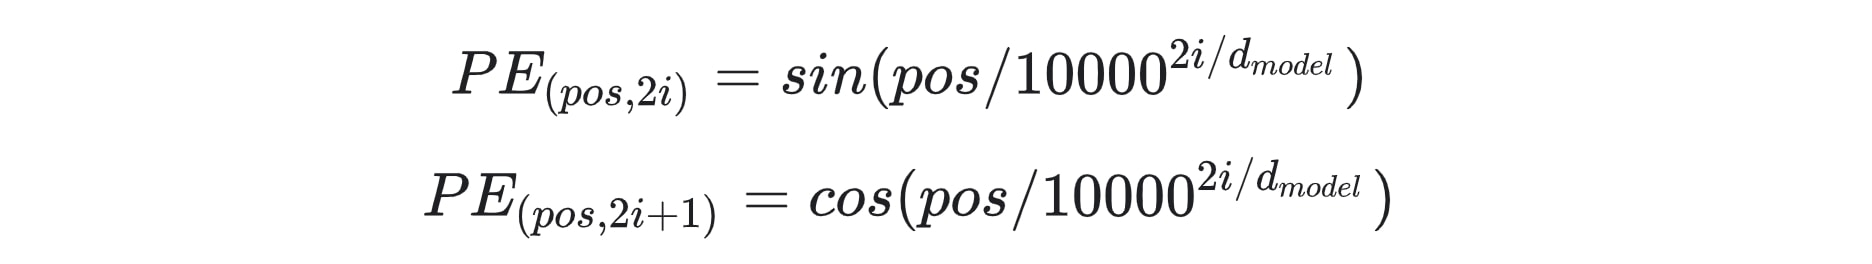


论文里头提到他们之所以这样设计位置编码（Positional Encoding, PE）是因为这个函数有个很好的特性：给定任一位置pos 的位置编码PE(pos)，跟它距离k 个单位的位置pos + k 的位置编码PE(pos + k) 可以表示为PE(pos) 的一个线性函数（linear function）。

因此透过在 word embedding 里加入这样的资讯，作者们认为可以帮助 Transformer 学会 model 序列中的子词的相对位置关系。

就算我们无法自己想出论文里头的位置编码公式，还是可以直接把 TensorFlow 官方的实作搬过来使用：

In [76]:
# 以下直接參考 TensorFlow 官方 tutorial 
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)


seq_len = 50
d_model = 512

pos_encoding = positional_encoding(seq_len, d_model)
pos_encoding

<tf.Tensor: id=1311738, shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147096,  0.8218562 ,  0.8019618 , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.9092974 ,  0.9364147 ,  0.95814437, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 0.12357312,  0.97718984, -0.24295525, ...,  0.9999863 ,
          0.99998724,  0.99998814],
        [-0.76825464,  0.7312359 ,  0.63279754, ...,  0.9999857 ,
          0.9999867 ,  0.9999876 ],
        [-0.95375264, -0.14402692,  0.99899054, ...,  0.9999851 ,
          0.9999861 ,  0.9999871 ]]], dtype=float32)>

一路看下来你应该也可以猜到位置编码的每一维意义了：

第 1 维代表 batch_size，之后可以 broadcasting
第 2 维是序列长度，我们会为每个在输入 / 输出序列里头的子词都加入位置编码
第 3 维跟词嵌入向量同维度
因为是要跟词嵌入向量相加，位置编码的维度也得是 d_model。我们也可以把位置编码画出感受一下：

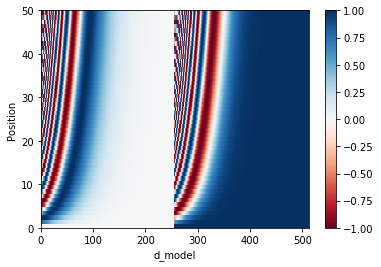

In [77]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d_model')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

这图你应该在很多教学文章以及教授的影片里都看过了。就跟我们前面看过的各种 2 维矩阵相同，x 轴代表着跟词嵌入向量相同的维度 d_model，y 轴则代表序列中的每个位置。之后我们会看输入 / 输出序列有多少个子词，就加入几个位置编码。


### 6.5 Encoder

Encoder里头主要包含了3个元件：  
输入的词嵌入层  
位置编码  
N个Encoder layers  
大部分的工作都交给Encoder layer小弟做了，因此Encoder的实作很单纯：

In [78]:
class Encoder(tf.keras.layers.Layer):
  # Encoder 的初始參數除了本來就要給 EncoderLayer 的參數還多了：
  # - num_layers: 決定要有幾個 EncoderLayers, 前面影片中的 `N`
  # - input_vocab_size: 用來把索引轉成詞嵌入向量
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    # 建立 `num_layers` 個 EncoderLayers
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):
    # 輸入的 x.shape == (batch_size, input_seq_len)
    # 以下各 layer 的輸出皆為 (batch_size, input_seq_len, d_model)
    input_seq_len = tf.shape(x)[1]
    
    # 將 2 維的索引序列轉成 3 維的詞嵌入張量，並依照論文乘上 sqrt(d_model)
    # 再加上對應長度的位置編碼
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :input_seq_len, :]

    # 對 embedding 跟位置編碼的總合做 regularization
    # 這在 Decoder 也會做
    x = self.dropout(x, training=training)
    
    # 通過 N 個 EncoderLayer 做編碼
    for i, enc_layer in enumerate(self.enc_layers):
      x = enc_layer(x, training, mask)
      # 以下只是用來 demo EncoderLayer outputs
      #print('-' * 20)
      #print(f"EncoderLayer {i + 1}'s output:", x)
      
    
    return x 

依照论文将word embedding乘上sqrt（d_model），并在embedding跟位置编码相加以后通过dropout层来达到regularization的效果。

现在我们可以直接将索引序列inp丢入Encoder：

In [79]:
# 超參數
num_layers = 2 # 2 層的 Encoder
d_model = 4
num_heads = 2
dff = 8
input_vocab_size = subword_encoder_en.vocab_size + 2 # 記得加上 <start>, <end>

# 初始化一個 Encoder
encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size)

# 將 2 維的索引序列丟入 Encoder 做編碼
enc_out = encoder(inp, training=False, mask=None)
print("inp:", inp)
print("-" * 20)
print("enc_out:", enc_out)

inp: tf.Tensor(
[[8135  105   10 1304 7925 8136    0    0]
 [8135   17 3905 6013   12 2572 7925 8136]], shape=(2, 8), dtype=int64)
--------------------
enc_out: tf.Tensor(
[[[-0.80654085 -0.58460367 -0.31439862  1.7055432 ]
  [-0.4689116  -0.5740813  -0.68403816  1.727031  ]
  [-0.319709   -0.1778252  -1.1191479   1.616682  ]
  [-0.4927411   0.26990715 -1.2412689   1.4641027 ]
  [-0.88477194  0.16279432 -0.8493917   1.5713695 ]
  [-0.96625364 -0.25279236 -0.4533521   1.6723981 ]
  [-0.8476429  -0.5615219  -0.28872436  1.6978891 ]
  [-0.6195776  -0.59192634 -0.5193857   1.7308896 ]]

 [[-0.8083885  -0.56457376 -0.33460817  1.7075703 ]
  [-0.5015203  -0.5214132  -0.7037289   1.7266623 ]
  [-0.34244898 -0.1131379  -1.144456    1.600043  ]
  [-0.5072438   0.21401638 -1.2050332   1.4982605 ]
  [-0.88611245  0.2636847  -0.9036026   1.5260304 ]
  [-0.96629435 -0.2108366  -0.49055374  1.6676848 ]
  [-0.868328   -0.5383214  -0.2883606   1.6950098 ]
  [-0.6246328  -0.57586765 -0.5305909   1.7310

注意因为Encoder已经包含了词嵌入层，因此我们不用再像呼叫Encoder layer时一样还得自己先做word embedding。现在的输入及输出张量为：  

输入：（batch_size，seq_len）  
输出：（batch_size，seq_len，d_model）  
有了Encoder，我们之后就可以直接把2维的索引序列inp丢入Encoder，让它帮我们把里头所有的英文序列做一连串的转换。

### 6.6 Decoder

Decoder layer本来就只跟Encoder layer差在一个MHA，而这逻辑被包起来以后呼叫它的Decoder做的事情就跟Encoder基本上没有两样了。

在Decoder里头我们只需要建立一个专门给中文用的词嵌入层以及位置编码即可。我们在呼叫每个Decoder layer的时候也顺便把其注意权重存下来，方便我们了解模型训练完后是怎么做翻译的。

In [80]:
class Decoder(tf.keras.layers.Layer):
  # 初始參數跟 Encoder 只差在用 `target_vocab_size` 而非 `inp_vocab_size`
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    
    # 為中文（目標語言）建立詞嵌入層
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  # 呼叫時的參數跟 DecoderLayer 一模一樣
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    
    tar_seq_len = tf.shape(x)[1]
    attention_weights = {}  # 用來存放每個 Decoder layer 的注意權重
    
    # 這邊跟 Encoder 做的事情完全一樣
    x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :tar_seq_len, :]
    x = self.dropout(x, training=training)

    
    for i, dec_layer in enumerate(self.dec_layers):
      x, block1, block2 = dec_layer(x, enc_output, training,
                                    combined_mask, inp_padding_mask)
      
      # 將從每個 Decoder layer 取得的注意權重全部存下來回傳，方便我們觀察
      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
    
    # x.shape == (batch_size, tar_seq_len, d_model)
    return x, attention_weights

In [81]:
# 超參數
num_layers = 2 # 2 層的 Decoder
d_model = 4
num_heads = 2
dff = 8
target_vocab_size = subword_encoder_zh.vocab_size + 2 # 記得加上 <start>, <end>

# 遮罩
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化一個 Decoder
decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size)

# 將 2 維的索引序列以及遮罩丟入 Decoder
print("tar:", tar)
print("-" * 20)
print("combined_mask:", combined_mask)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("inp_padding_mask:", inp_padding_mask)
print("-" * 20)
dec_out, attn = decoder(tar, enc_out, training=False, 
                        combined_mask=combined_mask,
                        inp_padding_mask=inp_padding_mask)
print("dec_out:", dec_out)
print("-" * 20)
for block_name, attn_weights in attn.items():
  print(f"{block_name}.shape: {attn_weights.shape}")

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 10, 10), dtype=float32)
--------------------
enc_out: tf.Tensor(
[[[-0.80654085 

麻雀虽小，五脏俱全。虽然我们是使用demo数据，但基本上这就是你在呼叫Decoder时需要做的所有事情：

初始时给它中文（目标语言）的字典大小、其他超参数
输入中文batch的索引序列
也要输入两个掩码以及Encoder输出enc_out
Decoder的输出你现在应该都可以很轻松地解读才是。基本上跟Decoder layer一模一样，只差在我们额外输出一个Python dict，里头存放所有Decoder layers的注意权重。

## 7 第一个Transformer

没错，终于到了这个时刻。在实作Transformer之前先点击视频来简单回顾一下我们在这一章实作了什么些玩意儿：

看看Transformer的实作

In [82]:
# Transformer 之上已經沒有其他 layers 了，我們使用 tf.keras.Model 建立一個模型
class Transformer(tf.keras.Model):
  # 初始參數包含 Encoder & Decoder 都需要超參數以及中英字典數目
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)
    # 這個 FFN 輸出跟中文字典一樣大的 logits 數，等通過 softmax 就代表每個中文字的出現機率
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  # enc_padding_mask 跟 dec_padding_mask 都是英文序列的 padding mask，
  # 只是一個給 Encoder layer 的 MHA 用，一個是給 Decoder layer 的 MHA 2 使用
  def call(self, inp, tar, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, combined_mask, dec_padding_mask)
    
    # 將 Decoder 輸出通過最後一個 linear layer
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

被输入Transformer的多个2维英文张量inp会一路通过Encoder里头的词嵌入层，位置编码以及N个Encoder layers后被转换成Encoder输出enc_output，接着对应的中文序列tar则会在Decoder里头走过相似的旅程并在每一层的Decoder layer利用MHA 2关注Encoder的输出enc_output，最后被Decoder输出。

而Decoder的输出dec_output则会通过Final linear layer，被转成进入Softmax前的logits final_output，其logit的数目则跟中文字典里的子词数相同。

因为Transformer把Decoder也包起来了，现在我们连Encoder输出enc_output也不用管，只要把英文（来源）以及中文（目标）的索引序列batch丢入Transformer，它就会输出最后一维为中文字典大小的张量。第2维是输出序列，里头每一个位置的向量就代表着该位置的中文字的机率分布（事实上通过softmax才是，但这边先这样说方便你理解）：
输入：
英文序列：（batch_size，inp_seq_len）

中文序列：（batch_size，tar_seq_len）

输出：
生成序列：（batch_size，tar_seq_len，target_vocab_size）

注意权重的dict

让我们马上建一个Transformer，并假设我们已经准备好用demo数据来训练它做英翻中：

In [83]:
# 超參數
num_layers = 1
d_model = 4
num_heads = 2
dff = 8

# + 2 是為了 <start> & <end> token
input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2

# 重點中的重點。訓練時用前一個字來預測下一個中文字
tar_inp = tar[:, :-1]
tar_real = tar[:, 1:]

# 來源 / 目標語言用的遮罩。注意 `comined_mask` 已經將目標語言的兩種遮罩合而為一
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar_inp)
look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化我們的第一個 transformer
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          input_vocab_size, output_vocab_size)

# 將英文、中文序列丟入取得 Transformer 預測下個中文字的結果
predictions, attn_weights = transformer(inp, tar_inp, False, inp_padding_mask, 
                                        combined_mask, inp_padding_mask)

print("tar:", tar)
print("-" * 20)
print("tar_inp:", tar_inp)
print("-" * 20)
print("tar_real:", tar_real)
print("-" * 20)
print("predictions:", predictions)

tar: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0    0]
 [4201  162  467  421  189   14    7  553    3 4202]], shape=(2, 10), dtype=int64)
--------------------
tar_inp: tf.Tensor(
[[4201   10  241   80   27    3 4202    0    0]
 [4201  162  467  421  189   14    7  553    3]], shape=(2, 9), dtype=int64)
--------------------
tar_real: tf.Tensor(
[[  10  241   80   27    3 4202    0    0    0]
 [ 162  467  421  189   14    7  553    3 4202]], shape=(2, 9), dtype=int64)
--------------------
predictions: tf.Tensor(
[[[ 0.00929453 -0.01123782  0.05421777 ... -0.01170466  0.00628542
   -0.07576236]
  [ 0.03640017 -0.01885041  0.0511385  ... -0.02349908  0.01716622
   -0.06729949]
  [ 0.05617092 -0.02265774  0.04667147 ... -0.02913139  0.0241506
   -0.05331099]
  ...
  [ 0.00905136 -0.01058669  0.05486142 ... -0.01039154  0.0058039
   -0.07445519]
  [ 0.02215609 -0.0147804   0.05375389 ... -0.0170105   0.01135763
   -0.07241639]
  [ 0.0478656  -0.02148081  0.04837158 ... -0.02759

有了前面的各种layers，建立一个Transformer并不难。但要输入什么数据就是一门大学问了

为何是丢少了尾巴一个字的tar_inp序列进去Transformer，而不是直接丢tar呢？

别忘记我们才刚初始一个Transformer，里头所有layers的权重都是随机的，你可不能指望它真的会什么「黑魔法」来帮你翻译。我们得先训练才行。但训练时如果你把整个正确的中文序列tar都进去给Transformer看，你期待它产生什么？一首新的中文诗吗？

如果你曾经实作过序列生成模型或是看过我之前的语言模型文章，就会知道在序列生成任务里头，模型获得的正确答案是输入序列往左位移一个位置的结果。

这样讲很抽象，让我们看个视频了解序列生成是怎么运作的：

你现在应该明白Transformer在训练的时候并不是吃整个中文序列，而是吃一个去掉尾巴的序列tar_inp，然后试着去预测「左移」一个字以后的序列tar_real。同样概念当然也可以运用到以RNN或是CNN-based的模型上面。

从视频中你也可以发现给定tar_inp序列中的任一位置，其对应位置的tar_real就是下个时间点模型应该要预测的中文字。

序列生成任务可以被视为是一个分类任务（Classification），而每一个中文字都是一个分类。而Transformer就是要去产生一个中文字的机率分布，想办法跟正解越接近越好。

跟用已训练的Transformer做预测时不同，在训练时为了稳定模型表现，我们并不会将Transformer的输出再度丢回去当做其输入（人形蜈蚣？），而是像视频中所示，给它左移一个位置后的序列tar_real当作正解让它去最小化error。

这种无视模型预测结果，而将正确解答丢入的训练方法一般被称作teacher forcing。你也可以参考教授的Sequence-to-sequence Learning教学。

### 6.7 定义损失函数与指标

因为被视为是一个分类任务，我们可以使用cross entropy来计算序列生成任务中实际的中文字跟模型预测的中文字分布（distribution）相差有多远。

这边简单定义一个损失函式：

In [84]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# 假設我們要解的是一個 binary classifcation， 0 跟 1 個代表一個 label
real = tf.constant([1, 1, 0], shape=(1, 3), dtype=tf.float32)
pred = tf.constant([[0, 1], [0, 1], [0, 1]], dtype=tf.float32)
loss_object(real, pred)

<tf.Tensor: id=1314674, shape=(3,), dtype=float32, numpy=array([0.31326166, 0.31326166, 1.3132616 ], dtype=float32)>

如果你曾做过分类问题，应该能看出预测序列pred里头的第3个预测结果出错因此entropy值上升。损失函数loss_object做的事情就是比较2个序列并计算cross entropy：

real：一个包含N个正确labels的序列

pred：一个包含N个维度为label数的logit序列

我们在这边将reduction参数设为none，请loss_object不要把每个位置的error加总。而这是因为我们之后要自己把<pad> token出现的位置的损失舍弃不计。

而将from_logits参数设为True是因为从Transformer得到的预测还没有经过softmax，因此加总还不等于1：

In [85]:
print("predictions:", predictions)
print("-" * 20)
print(tf.reduce_sum(predictions, axis=-1))

predictions: tf.Tensor(
[[[ 0.00929453 -0.01123782  0.05421777 ... -0.01170466  0.00628542
   -0.07576236]
  [ 0.03640017 -0.01885041  0.0511385  ... -0.02349908  0.01716622
   -0.06729949]
  [ 0.05617092 -0.02265774  0.04667147 ... -0.02913139  0.0241506
   -0.05331099]
  ...
  [ 0.00905136 -0.01058669  0.05486142 ... -0.01039154  0.0058039
   -0.07445519]
  [ 0.02215609 -0.0147804   0.05375389 ... -0.0170105   0.01135763
   -0.07241639]
  [ 0.0478656  -0.02148081  0.04837158 ... -0.02759764  0.02148173
   -0.06043392]]

 [[ 0.00996658 -0.01115558  0.05453676 ... -0.0114185   0.00637141
   -0.07500792]
  [ 0.03897631 -0.01930442  0.0508956  ... -0.02409907  0.01803425
   -0.0656432 ]
  [ 0.05387272 -0.02244362  0.04702405 ... -0.02893805  0.02348556
   -0.05554678]
  ...
  [ 0.01048942 -0.01085558  0.05502524 ... -0.01070841  0.0062833
   -0.07385261]
  [ 0.02370835 -0.01504852  0.05381611 ... -0.01732858  0.01186723
   -0.07158875]
  [ 0.04920104 -0.02166032  0.0481827  ... -0.027812

有了loss_object实际算cross entropy以后，我们需要另外一个函式来建立掩码并加总序列里头不包含` token位置的损失：

In [86]:
def loss_function(real, pred):
  # 這次的 mask 將序列中不等於 0 的位置視為 1，其餘為 0 
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # 照樣計算所有位置的 cross entropy 但不加總
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask  # 只計算非 <pad> 位置的損失 
  
  return tf.reduce_mean(loss_)

我另外再定义两个tf.keras.metrics，方便之后使用TensorBoard来追踪模型performance：

In [87]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 7.设置超参数

前面实作了那么多layers，你应该还记得有哪些是你自己可以调整的超参数吧？

让我帮你全部列出来：

num_layers决定Transfomer里头要有几个Encoder / Decoder layers

d_model决定我们子词的representation space维度

num_heads要做几头的自注意力运算

dff决定FFN的中间维度

dropout_rate预设0.1，一般用预设值即可

input_vocab_size：输入语言（英文）的字典大小

target_vocab_size：输出语言（中文）的字典大小

论文里头最基本的Transformer配置为：
num_layers=6
d_model=512
dff=2048

有大量数据以及大的Transformer，你可以在很多机器学习任务都达到不错的成绩。为了不要让训练时间太长，在这篇文章里头我会把Transformer里头的超参数设小一点：

In [88]:
num_layers = 4 
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  # 預設值

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 8137
target_vocab_size: 4203


## 8.设置Optimizer

我们在这边跟论文一致，使用Adam optimizer以及自定义的learning rate scheduler：

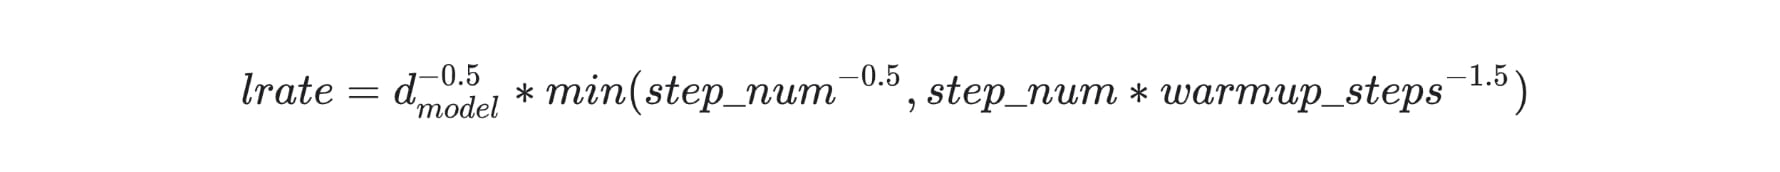

这schedule让训练过程的前warmup_steps的learning rate线性增加，在那之后则跟步骤数step_num的反平方根成比例下降。不用担心你没有完全理解这公式，我们一样可以直接使用TensorFlow官方教学的实作：

In [89]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # 論文預設 `warmup_steps` = 4000
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
# 將客製化 learning rate schdeule 丟入 Adam opt.
# Adam opt. 的參數都跟論文相同
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

我们可以观察看看这个schedule是怎么随着训练步骤而改变learning rate的：

Text(0.5, 0, 'Train Step')

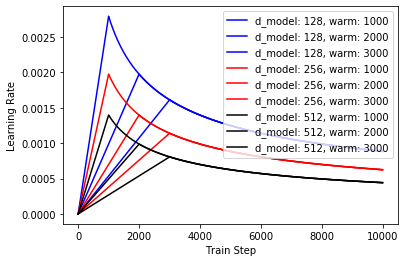

In [90]:
d_models = [128, 256, 512]
warmup_steps = [1000 * i for i in range(1, 4)]

schedules = []
labels = []
colors = ["blue", "red", "black"]
for d in d_models:
  schedules += [CustomSchedule(d, s) for s in warmup_steps]
  labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

for i, (schedule, label) in enumerate(zip(schedules, labels)):
  plt.plot(schedule(tf.range(10000, dtype=tf.float32)), 
           label=label, color=colors[i // 3])

plt.legend()

plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

你可以明显地看到所有schedules都先经过warmup_steps个步骤直线提升learning rate，接着逐渐平滑下降。另外我们也会给比较高维的d_model维度比较小的learning rate。

## 9.实际训练以及定时存盘

好啦，什么都准备齐全了，让我们开始训练Transformer吧！记得使用前面已经定义好的超参数来初始化一个全新的Transformer：

In [91]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

print(f"""這個 Transformer 有 {num_layers} 層 Encoder / Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}

""")

這個 Transformer 有 4 層 Encoder / Decoder layers
d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 8137
target_vocab_size: 4203
dropout_rate: 0.1




打游戏时你会记得要定期存盘以防任何意外发生，训练深度学习模型也是同样道理。设置checkpoint来定期储存/读取模型及optimizer是必备的。

我们在底下会定义一个checkpoint路径，此路径包含了各种超参数的信息，方便之后比较不同实验的结果并加载已训练的进度。我们也需要一个checkpoint manager来做所有跟存读模型有关的杂事，并只保留最新5个checkpoints以避免占用太多空间：

In [92]:
# 方便比較不同實驗/ 不同超參數設定的結果
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{train_perc}train_perc"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

# tf.train.Checkpoint 可以幫我們把想要存下來的東西整合起來，方便儲存與讀取
# 一般來說你會想存下模型以及 optimizer 的狀態
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# ckpt_manager 會去 checkpoint_path 看有沒有符合 ckpt 裡頭定義的東西
# 存檔的時候只保留最近 5 次 checkpoints，其他自動刪除
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果在 checkpoint 路徑上有發現檔案就讀進來
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  
  # 用來確認之前訓練多少 epochs 了
  last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
  print(f'已讀取最新的 checkpoint，模型已訓練 {last_epoch} epochs。')
else:
  last_epoch = 0
  print("沒找到 checkpoint，從頭訓練。")

沒找到 checkpoint，從頭訓練。


我仍会秀出完整的训练代码让你可以执行第一次的训练。当你想要依照本文训练自己的Transformer时会感谢有checkpoint manager的存在。现在假设我们还没有checkpoints。

在实际训练Transformer之前还需要定义一个简单函式来产生所有的掩码

In [93]:
def create_masks(inp, tar):
  # 英文句子的 padding mask，要交給 Encoder layer 自注意力機制用的
  enc_padding_mask = create_padding_mask(inp)
  
  # 同樣也是英文句子的 padding mask，但是是要交給 Decoder layer 的 MHA 2 
  # 關注 Encoder 輸出序列用的
  dec_padding_mask = create_padding_mask(inp)
  
  # Decoder layer 的 MHA1 在做自注意力機制用的
  # `combined_mask` 是中文句子的 padding mask 跟 look ahead mask 的疊加
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

如果没有本文前面针对掩码的详细说明，很多第一次实作的人得花不少时间来确实地掌握这些掩码的用途。不过对现在的你来说应该也是小菜一碟。

一个数据集包含多个batch，而每次拿一个batch来训练的步骤就称作train_step。为了让代码更简洁以及容易优化，我们会定义Transformer在一次训练步骤（处理一个batch）所需要做的所有事情。

不限于Transformer，一般来说train_step函式里会有几个重要步骤：

对训练数据做些必要的前处理

将数据丢入模型，取得预测结果

用预测结果跟正确解答计算loss

取出梯度并利用optimizer做梯度下降

有了这个概念以后看看代码：

In [94]:
@tf.function  # 讓 TensorFlow 幫我們將 eager code 優化並加快運算
def train_step(inp, tar):
  # 前面說過的，用去尾的原始序列去預測下一個字的序列
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  # 建立 3 個遮罩
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  # 紀錄 Transformer 的所有運算過程以方便之後做梯度下降
  with tf.GradientTape() as tape:
    # 注意是丟入 `tar_inp` 而非 `tar`。記得將 `training` 參數設定為 True
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    # 跟影片中顯示的相同，計算左移一個字的序列跟模型預測分佈之間的差異，當作 loss
    loss = loss_function(tar_real, predictions)

  # 取出梯度並呼叫前面定義的 Adam optimizer 幫我們更新 Transformer 裡頭可訓練的參數
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  # 將 loss 以及訓練 acc 記錄到 TensorBoard 上，非必要
  train_loss(loss)
  train_accuracy(tar_real, predictions)

如果你曾经以TensorFlow 2实作过稍微复杂一点的模型，应该就知道train_step函式的写法非常固定：

对输入数据做些前处理（本文中的掩码、将输出序列左移当成正解etc.）

利用tf.GradientTape轻松记录数据被模型做的所有转换并计算loss

将梯度取出并让optimzier对可被训练的权重做梯度下降（上升）

你完全可以用一模一样的方式将任何复杂模型的处理过程包在train_step函式，这样可以让我们之后在iterate数据集时非常轻松。而且最重要的是可以用tf.function来提高此函式里头运算的速度。你可以点击连接来了解更多。

处理一个batch的train_step函式也有了，就只差写个for loop将数据集跑个几遍了。我之前的模型虽然训练了50个epochs，但事实上大概30 epochs翻译的结果就差不多稳定了。所以让我们将EPOCHS设定为30：

In [95]:
# 定義我們要看幾遍數據集
EPOCHS = 30
print(f"此超參數組合的 Transformer 已經訓練 {last_epoch} epochs。")
print(f"剩餘 epochs：{min(0, last_epoch - EPOCHS)}")


# 用來寫資訊到 TensorBoard，非必要但十分推薦
summary_writer = tf.summary.create_file_writer(log_dir)

# 比對設定的 `EPOCHS` 以及已訓練的 `last_epoch` 來決定還要訓練多少 epochs
for epoch in range(last_epoch, EPOCHS):
  start = time.time()
  
  # 重置紀錄 TensorBoard 的 metrics
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # 一個 epoch 就是把我們定義的訓練資料集一個一個 batch 拿出來處理，直到看完整個數據集 
  for (step_idx, (inp, tar)) in enumerate(train_dataset):
    
    # 每次 step 就是將數據丟入 Transformer，讓它生預測結果並計算梯度最小化 loss
    train_step(inp, tar)  

  # 每個 epoch 完成就存一次檔    
  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  # 將 loss 以及 accuracy 寫到 TensorBoard 上
  with summary_writer.as_default():
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
    tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
  
  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
  print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

此超參數組合的 Transformer 已經訓練 0 epochs。
剩餘 epochs：-30


Saving checkpoint for epoch 1 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-1
Epoch 1 Loss 5.1923 Accuracy 0.0195
Time taken for 1 epoch: 160.75584244728088 secs

Saving checkpoint for epoch 2 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-2
Epoch 2 Loss 4.2494 Accuracy 0.0602
Time taken for 1 epoch: 70.88964653015137 secs

Saving checkpoint for epoch 3 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-3
Epoch 3 Loss 3.7417 Accuracy 0.0992
Time taken for 1 epoch: 78.86248826980591 secs

Saving checkpoint for epoch 4 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-4
Epoch 4 Loss 3.2635 Accuracy 0.1532
Time taken for 1 epoch: 72.72761845588684 secs

Saving checkpoint for epoch 5 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-5
Epoch 5 Loss 2.9615 Accuracy 0.1822
Time taken for 1 epoch: 72.61794018745422 secs

Saving checkpoint for epoch 6 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-6
Epo

是的，如果你真的只是想要训练个模型，什么其他事情都不想考虑的话那你可以：

In [96]:
# 87 分，不能再高了。
#for epoch in range(EPOCHS):
#  for inp, tar in train_dataset:
#    train_step(inp, tar)

事实上我们定义的4层Transformer大约每70秒就可以看完一遍有3万笔训练例子的数据集，而且你从上面的loss以及accuracy可以看出来Transformer至少在训练集里头进步地挺快的。

而就我自己的观察大约经过30个epochs翻译结果就很稳定了。所以你大约只需半个小时就能有一个非常简单，有点水准的英翻中Transformer（在至少有个一般GPU的情况）。

但跟看上面的log比起来，我个人还是比较推荐使用TensorBoard。在TensorFlow 2里头，你甚至能直接在Jupyter Notebook或是Colab里头开启它：

In [97]:
%load_ext tensorboard
%tensorboard --logdir {your_log_dir}

透过TensorBoard，你能非常清楚地比较不同实验以及不同点子的效果，知道什么work什么不work，进而修正之后尝试的方向。如果只是简单写个print，那你永远只会看到最新一次训练过程的log，然后忘记之前到底发生过什么事。

## 10.实际进行英翻中

有了已经训练一阵子的Transformer，当然得拿它来实际做做翻译。

跟训练的时候不同，在做预测时我们不需做teacher forcing来稳定Transformer的训练过程。反之，我们将Transformer在每个时间点生成的中文索引加到之前已经生成的序列尾巴，并以此新序列作为其下一次的输入。这是因为Transformer事实上是一个自回归模型（Auto-regressive model）：依据自己生成的结果预测下次输出。

利用Transformer进行翻译（预测）的逻辑如下：

将输入的英文句子利用Subword Tokenizer转换成子词索引序列（还记得inp吧？）

在该英文索引序列前后加上代表英文BOS / EOS的tokens

在Transformer输出序列长度达到MAX_LENGTH之前重复以下步骤：

为目前已经生成的中文索引序列产生新的掩码

将刚刚的英文序列、当前的中文序列以及各种掩码放入Transformer

将Transformer输出序列的最后一个位置的向量取出，并取argmax取得新的预测中文索引

将此索引加到目前的中文索引序列里头作为Transformer到此为止的输出结果

如果新生成的中文索引为<end>则代表中文翻译已全部生成完毕，直接回传

将最后得到的中文索引序列回传作为翻译结果

答案也很简单，因为Decoder可以透过「关注」Encoder处理完不同英文句子的输出来获得语义信息，了解它在当下该生成什么中文字作为第一个输出。

现在让我们定义一个evaluate函式实现上述逻辑。此函式的输入是一个完全没有经过处理的英文句子（以字串表示），输出则是一个索引序列，里头的每个索引就代表着Transformer预测的中文字。

让我们实际看看evaluate函式：

In [98]:
# 給定一個英文句子，輸出預測的中文索引數字序列以及注意權重 dict
def evaluate(inp_sentence):
  
  # 準備英文句子前後會加上的 <start>, <end>
  start_token = [subword_encoder_en.vocab_size]
  end_token = [subword_encoder_en.vocab_size + 1]
  
  # inp_sentence 是字串，我們用 Subword Tokenizer 將其變成子詞的索引序列
  # 並在前後加上 BOS / EOS
  inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # 跟我們在影片裡看到的一樣，Decoder 在第一個時間點吃進去的輸入
  # 是一個只包含一個中文 <start> token 的序列
  decoder_input = [subword_encoder_zh.vocab_size]
  output = tf.expand_dims(decoder_input, 0)  # 增加 batch 維度
  
  # auto-regressive，一次生成一個中文字並將預測加到輸入再度餵進 Transformer
  for i in range(MAX_LENGTH):
    # 每多一個生成的字就得產生新的遮罩
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    

    # 將序列中最後一個 distribution 取出，並將裡頭值最大的當作模型最新的預測字
    predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # 遇到 <end> token 就停止回傳，代表模型已經產生完結果
    if tf.equal(predicted_id, subword_encoder_zh.vocab_size + 1):
      return tf.squeeze(output, axis=0), attention_weights
    
    #將 Transformer 新預測的中文索引加到輸出序列中，讓 Decoder 可以在產生
    # 下個中文字的時候關注到最新的 `predicted_id`
    output = tf.concat([output, predicted_id], axis=-1)

  # 將 batch 的維度去掉後回傳預測的中文索引序列
  return tf.squeeze(output, axis=0), attention_weights

In [99]:
# 要被翻譯的英文句子
sentence = "China, India, and others have enjoyed continuing economic growth."

# 取得預測的中文索引序列
predicted_seq, _ = evaluate(sentence)

# 過濾掉 <start> & <end> tokens 並用中文的 subword tokenizer 幫我們將索引序列還原回中文句子
target_vocab_size = subword_encoder_zh.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("predicted_sentence:", predicted_sentence)

sentence: China, India, and others have enjoyed continuing economic growth.
--------------------
predicted_seq: tf.Tensor(
[4201   16    4   37  386  101    8   34   32    4   33  956  186   14
   22   52  107   84    1  104  735  104  292  378   76    3], shape=(26,), dtype=int32)
--------------------
predicted_sentence: 中国、印度和其他国家享受了经济增长的持久持续推动。


考虑到这个Transformer不算巨大（约400万个参数），且模型训练时用的数据集不大的情况下，我们达到相当不错的结果，你说是吧？在这个例子里头该翻的词汇都翻了出来，句子本身也还算自然。

In [100]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  1834624   
_________________________________________________________________
decoder_2 (Decoder)          multiple                  1596288   
_________________________________________________________________
dense_137 (Dense)            multiple                  542187    
Total params: 3,973,099
Trainable params: 3,973,099
Non-trainable params: 0
_________________________________________________________________


## 11.可视化注意权重

除了其运算高度平行以及表现不错以外，Transformer另外一个优点在于我们可以透过可视化注意权重（attention weights）来了解模型实际在生成序列的时候放「注意力」在哪里。别忘记我们当初在Decoder layers做完multi-head attention之后都将注意权重输出。现在正是它们派上用场的时候了。



先让我们看看有什么注意权重可以拿来可视化

In [101]:
predicted_seq, attention_weights = evaluate(sentence)

# 在這邊我們自動選擇最後一個 Decoder layer 的 MHA 2，也就是 Decoder 關注 Encoder 的 MHA
layer_name = f"decoder_layer{num_layers}_block2"

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("attention_weights.keys():")
for layer_name, attn in attention_weights.items():
  print(f"{layer_name}.shape: {attn.shape}")
print("-" * 20)
print("layer_name:", layer_name)

sentence: China, India, and others have enjoyed continuing economic growth.
--------------------
predicted_seq: tf.Tensor(
[4201   16    4   37  386  101    8   34   32    4   33  956  186   14
   22   52  107   84    1  104  735  104  292  378   76    3], shape=(26,), dtype=int32)
--------------------
attention_weights.keys():
decoder_layer1_block1.shape: (1, 8, 26, 26)
decoder_layer1_block2.shape: (1, 8, 26, 15)
decoder_layer2_block1.shape: (1, 8, 26, 26)
decoder_layer2_block2.shape: (1, 8, 26, 15)
decoder_layer3_block1.shape: (1, 8, 26, 26)
decoder_layer3_block2.shape: (1, 8, 26, 15)
decoder_layer4_block1.shape: (1, 8, 26, 26)
decoder_layer4_block2.shape: (1, 8, 26, 15)
--------------------
layer_name: decoder_layer4_block2


block1代表是Decoder layer自己关注自己的MHA 1，因此倒数两个维度都跟中文序列长度相同；block2则是Decoder layer用来关注Encoder输出的MHA 2，在这边我们选择最后一个Decoder layer的MHA 2来看Transformer在生成中文序列时关注在英文句子的那些位置。

但首先，我们得要有一个绘图的函式才行：

In [104]:
import matplotlib as mpl
# 你可能會需要自行下載一個中文字體檔案以讓 matplotlib 正確顯示中文
zhfont = mpl.font_manager.FontProperties(fname='/home/wumg/data/simhei.ttf')
plt.style.use("seaborn-whitegrid")

# 這個函式將英 -> 中翻譯的注意權重視覺化（注意：我們將注意權重 transpose 以最佳化渲染結果
def plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=None):
    
  fig = plt.figure(figsize=(17, 7))
  
  sentence = subword_encoder_en.encode(sentence)
  
  # 只顯示中文序列前 `max_len_tar` 個字以避免畫面太過壅擠
  if max_len_tar:
    predicted_seq = predicted_seq[:max_len_tar]
  else:
    max_len_tar = len(predicted_seq)
  
  # 將某一個特定 Decoder layer 裡頭的 MHA 1 或 MHA2 的注意權重拿出來並去掉 batch 維度
  attention_weights = tf.squeeze(attention_weights[layer_name], axis=0)  
  # (num_heads, tar_seq_len, inp_seq_len)
  
  # 將每個 head 的注意權重畫出
  for head in range(attention_weights.shape[0]):
    ax = fig.add_subplot(2, 4, head + 1)

    # [注意]我為了將長度不短的英文子詞顯示在 y 軸，將注意權重做了 transpose
    attn_map = np.transpose(attention_weights[head][:max_len_tar, :])
    ax.matshow(attn_map, cmap='viridis')  # (inp_seq_len, tar_seq_len)
    
    fontdict = {"fontproperties": zhfont}
    
    ax.set_xticks(range(max(max_len_tar, len(predicted_seq))))
    ax.set_xlim(-0.5, max_len_tar -1.5)
    
    ax.set_yticks(range(len(sentence) + 2))
    ax.set_xticklabels([subword_encoder_zh.decode([i]) for i in predicted_seq 
                        if i < subword_encoder_zh.vocab_size], 
                       fontdict=fontdict, fontsize=18)    
    
    ax.set_yticklabels(
        ['<start>'] + [subword_encoder_en.decode([i]) for i in sentence] + ['<end>'], 
        fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head + 1))
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
  
  plt.tight_layout()
  plt.show()
  plt.close(fig)

如果你直接把注意权重绘出的话y轴就会是每个中文字，而x轴则会是每个英文子词。而英文子词绘在x轴太占空间，我将每个注意权重都做transpose并呈现结果，这点你得注意一下。

让我们马上画出刚刚翻译的注意权重看看：

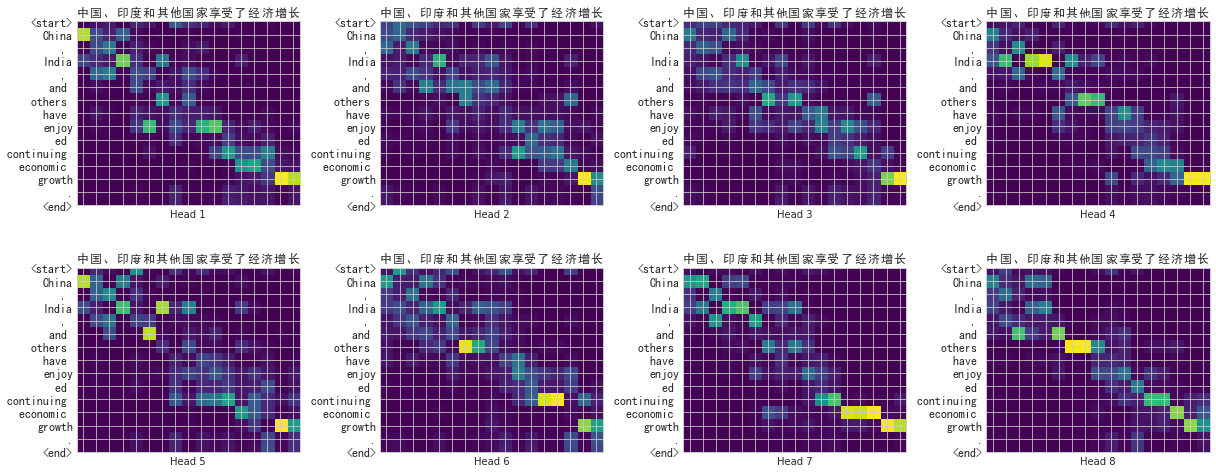

In [105]:
plot_attention_weights(attention_weights, sentence, 
                       predicted_seq, layer_name, max_len_tar=18)